In [1]:
import heist
import helpers
import torch.distributions
import torch

import gym
import random
import numpy as np
from helpers import generate_action, load_model
from procgen import ProcgenGym3Env
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_modified import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv

%load_ext autoreload
%autoreload 2

building procgen...done


In [3]:
class ModelActivations:
    def __init__(self, model):
        self.activations = {}
        self.model = model
        self.hooks = []  # To keep track of hooks

    def clear_hooks(self):
        # Remove all previously registered hooks
        for hook in self.hooks:
            hook.remove()
        self.hooks = []
        self.activations = {}

    def get_activation(self, name):
        def hook(model, input, output):
            processed_output = []
            for item in output:
                if isinstance(item, torch.Tensor):
                    processed_output.append(item.detach())
                elif isinstance(item, torch.distributions.Categorical):
                    processed_output.append(item.logits.detach())
                else:
                    processed_output.append(item)
            self.activations[name] = tuple(processed_output)
        return hook

    def register_hook_by_path(self, path, name):
        elements = path.split('.')
        model = self.model
        for i, element in enumerate(elements):
            if '[' in element:
                base, index = element.replace(']', '').split('[')
                index = int(index)
                model = getattr(model, base)[index]
            else:
                model = getattr(model, element)
            if i == len(elements) - 1:
                hook = model.register_forward_hook(self.get_activation(name))
                self.hooks.append(hook)  # Keep track of the hook

    def run_with_cache(self, input, layer_paths):
        self.clear_hooks()  # Clear any existing hooks
        self.activations = {}  # Reset activations
        for path in layer_paths:
            self.register_hook_by_path(path, path.replace('.', '_'))
        output = self.model(input)
        return output, self.activations



In [8]:
# Get an observation from the environment.

def plot_heist_observation(observation):
    # Define the colors to swap

    # Create a new figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))
    # Plot the modified observation
    ax.imshow(observation)

    # Remove the axis ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])

    # Display the plot
    plt.show()



/Users/paul/anaconda3/envs/procgen/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/paul/anaconda3/envs/procgen/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Users/paul/anaconda3/envs/procgen/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(


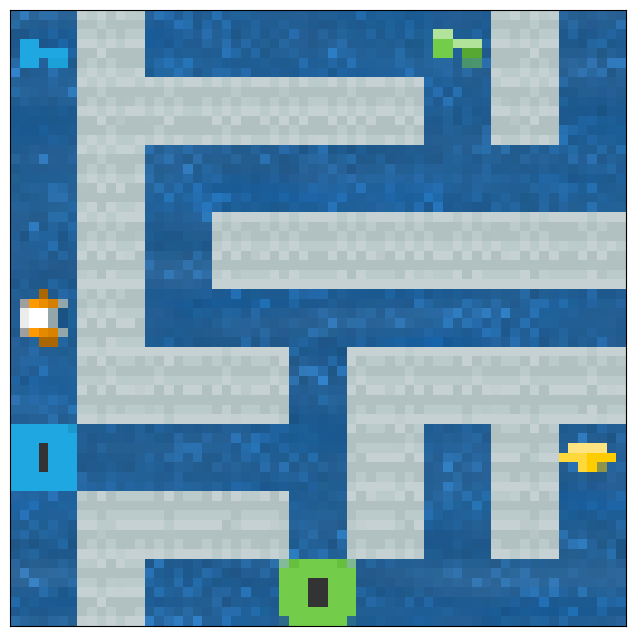

In [26]:
env_name = "procgen:procgen-heist-v0"  

env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 

model = load_model()

obs = env.reset()

plot_heist_observation(obs)

In [27]:



save_gif_option = True  
env_name = "procgen:procgen-heist-v0"  
for episode in range(1):    
    total_reward, frames, observations = heist.run_episode_and_save_as_gif(env, model, filepath=f'episode.gif', save_gif=save_gif_option)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")

/Users/paul/anaconda3/envs/procgen/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
/Users/paul/anaconda3/envs/procgen/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/Users/paul/anaconda3/envs/procgen/lib/python3.8/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):


Episode 1 finished with total reward: 0.0


In [ ]:
layer_paths = [
    'conv_seqs.0.conv',
    'conv_seqs.0.res_block0.conv0',
    'conv_seqs.0.res_block0.conv1',
    'conv_seqs.0.res_block1.conv0',
    'conv_seqs.0.res_block1.conv1',
    'conv_seqs.1.conv',
    'conv_seqs.1.res_block0.conv0',
    'conv_seqs.1.res_block0.conv1',
    'conv_seqs.1.res_block1.conv0',
    'conv_seqs.1.res_block1.conv1',
    'conv_seqs.2.conv',
    'conv_seqs.2.res_block0.conv0',
    'conv_seqs.2.res_block0.conv1',
    'conv_seqs.2.res_block1.conv0',
    'conv_seqs.2.res_block1.conv1',
    # Add other layers as needed
]

In [ ]:
model_activations = ModelActivations(model)
model_activations.clear_hooks()

obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

output, activations = model_activations.run_with_cache(obs, layer_paths)

In [ ]:
def plot_activations_for_layers(activations, layer_paths, save_filename_prefix=None):
    for layer_name in layer_paths:
        # Check if the specified layer's activations are available
        if layer_name not in activations:
            print(f"No activations found for layer: {layer_name}")
            continue

        # Extract the activation tensor for the specified layer
        activation_tensor = activations[layer_name][0].cpu().numpy()

        # The tensor is 3-dimensional [channels, height, width]
        num_activations = activation_tensor.shape[0]  # Number of activation maps
        
        # Calculate grid size
        grid_size = math.ceil(math.sqrt(num_activations))
        
        # Create a figure with dynamic subplots based on the number of activations
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(grid_size * 2, grid_size * 2))
        if grid_size == 1:
            axes = np.array([[axes]])  # Ensure axes can be indexed with two dimensions

        # Initialize an index for activation maps
        activation_idx = 0

        for i in range(grid_size):
            for j in range(grid_size):
                ax = axes[i, j]
                
                # Plot the activation map if we haven't gone through all of them yet
                if activation_idx < num_activations:
                    ax.imshow(activation_tensor[activation_idx, :, :], cmap='viridis', aspect='auto')
                    ax.set_title(f'Filter {activation_idx+1} {layer_name}', fontsize=8)
                    activation_idx += 1
                else:
                    ax.axis('off')  # Hide axes without data
                
                ax.axis('off')  # Hide axes for all plots for a cleaner look

        plt.tight_layout()
        
        # Save or show the plot
        if save_filename_prefix:
            save_filename = f"{save_filename_prefix}_{layer_name}.png"
            plt.savefig(save_filename)
            plt.close()
        else:
            plt.show()



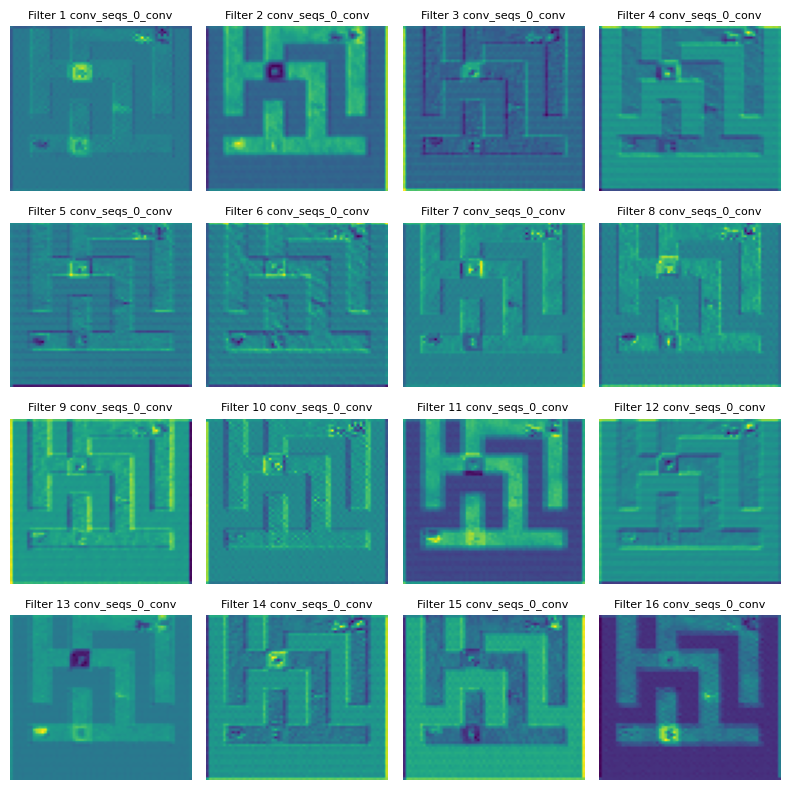

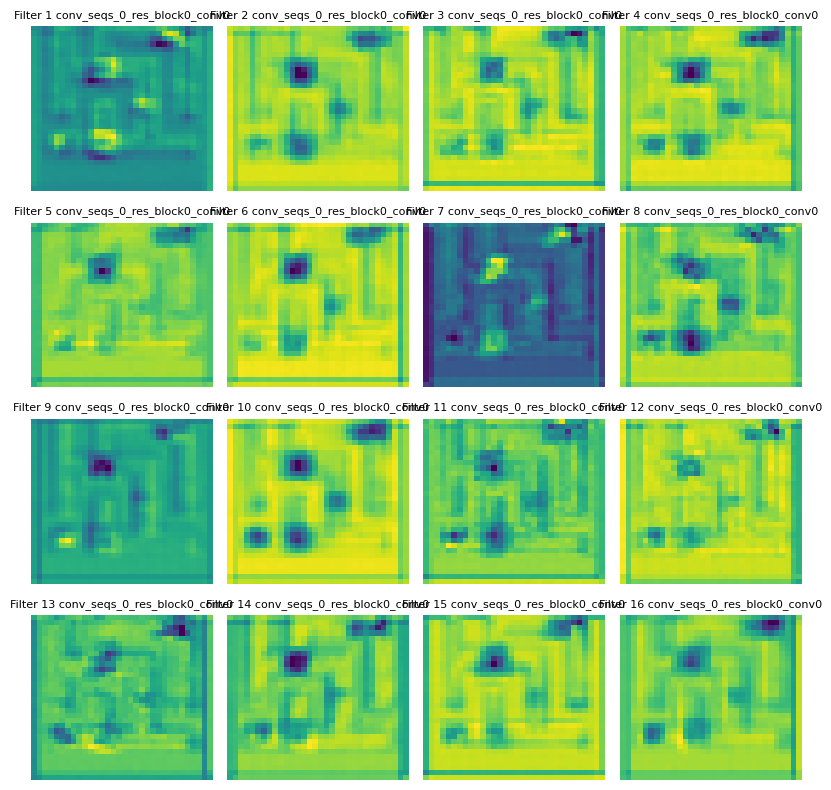

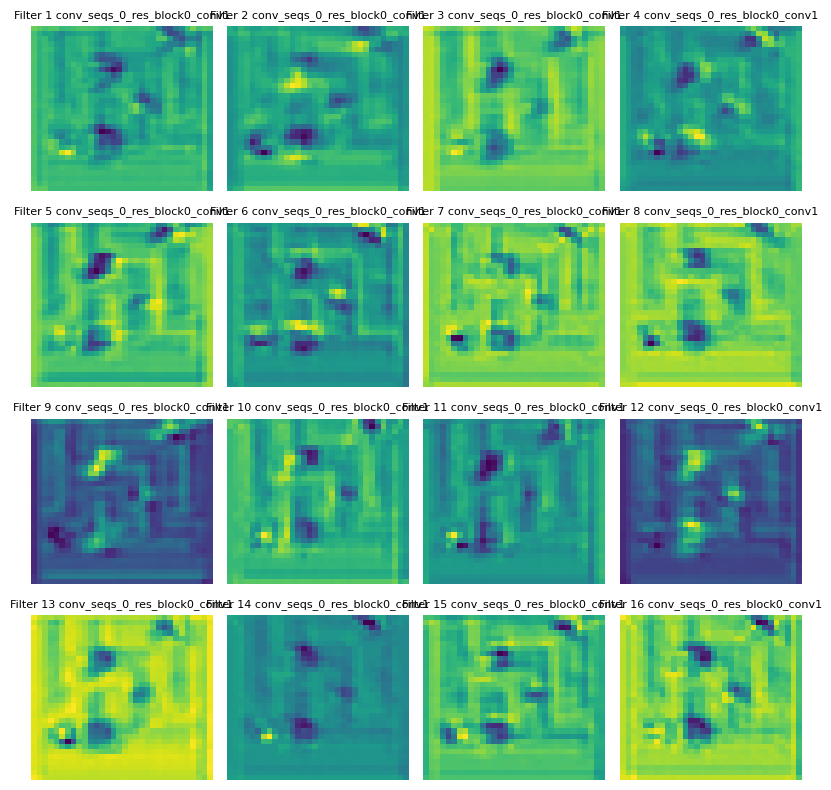

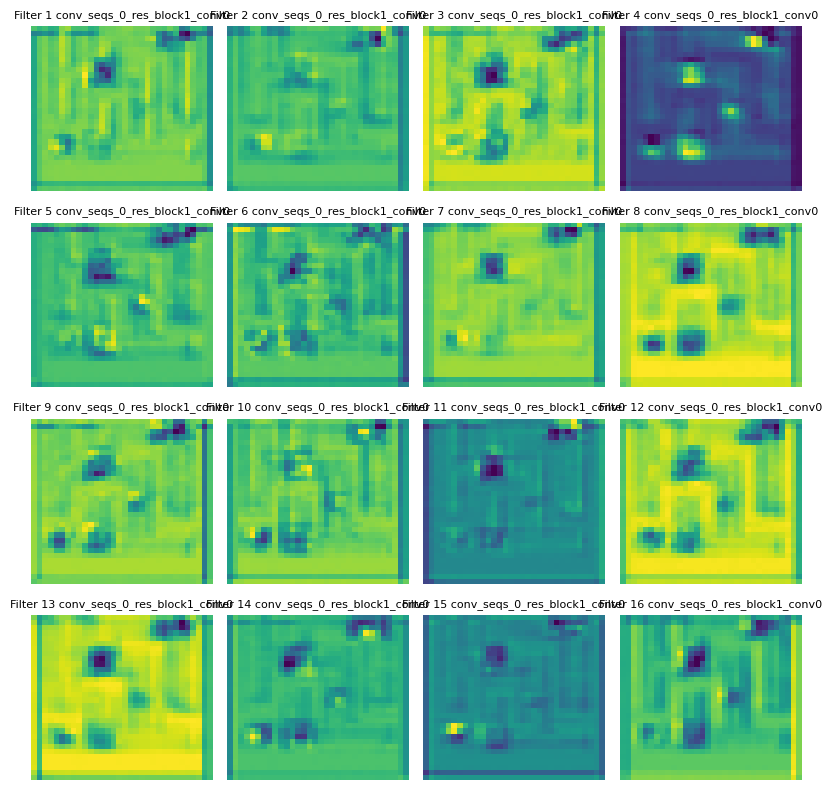

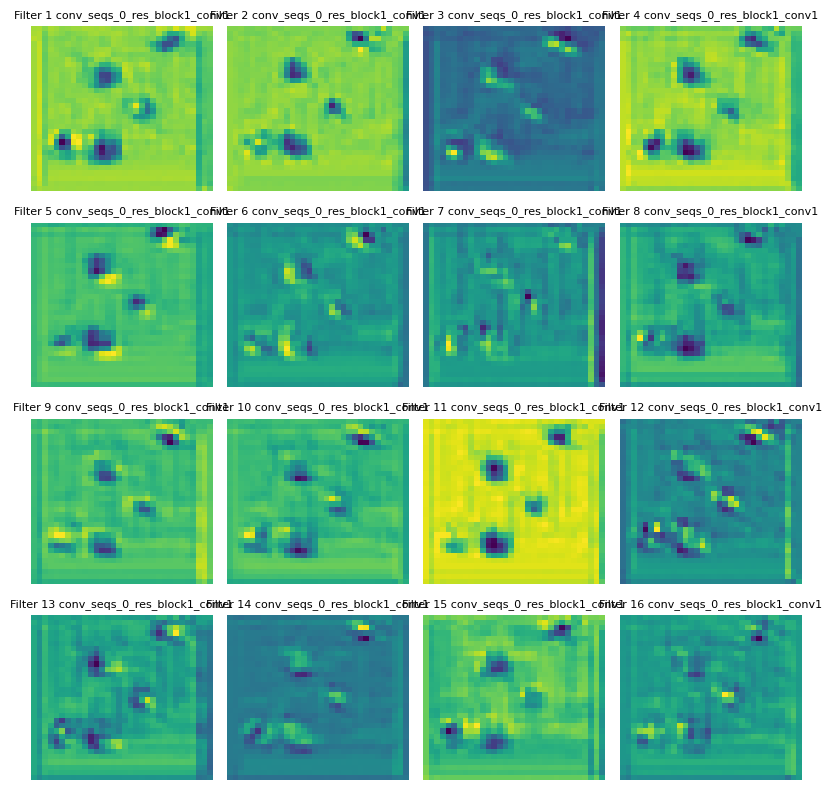

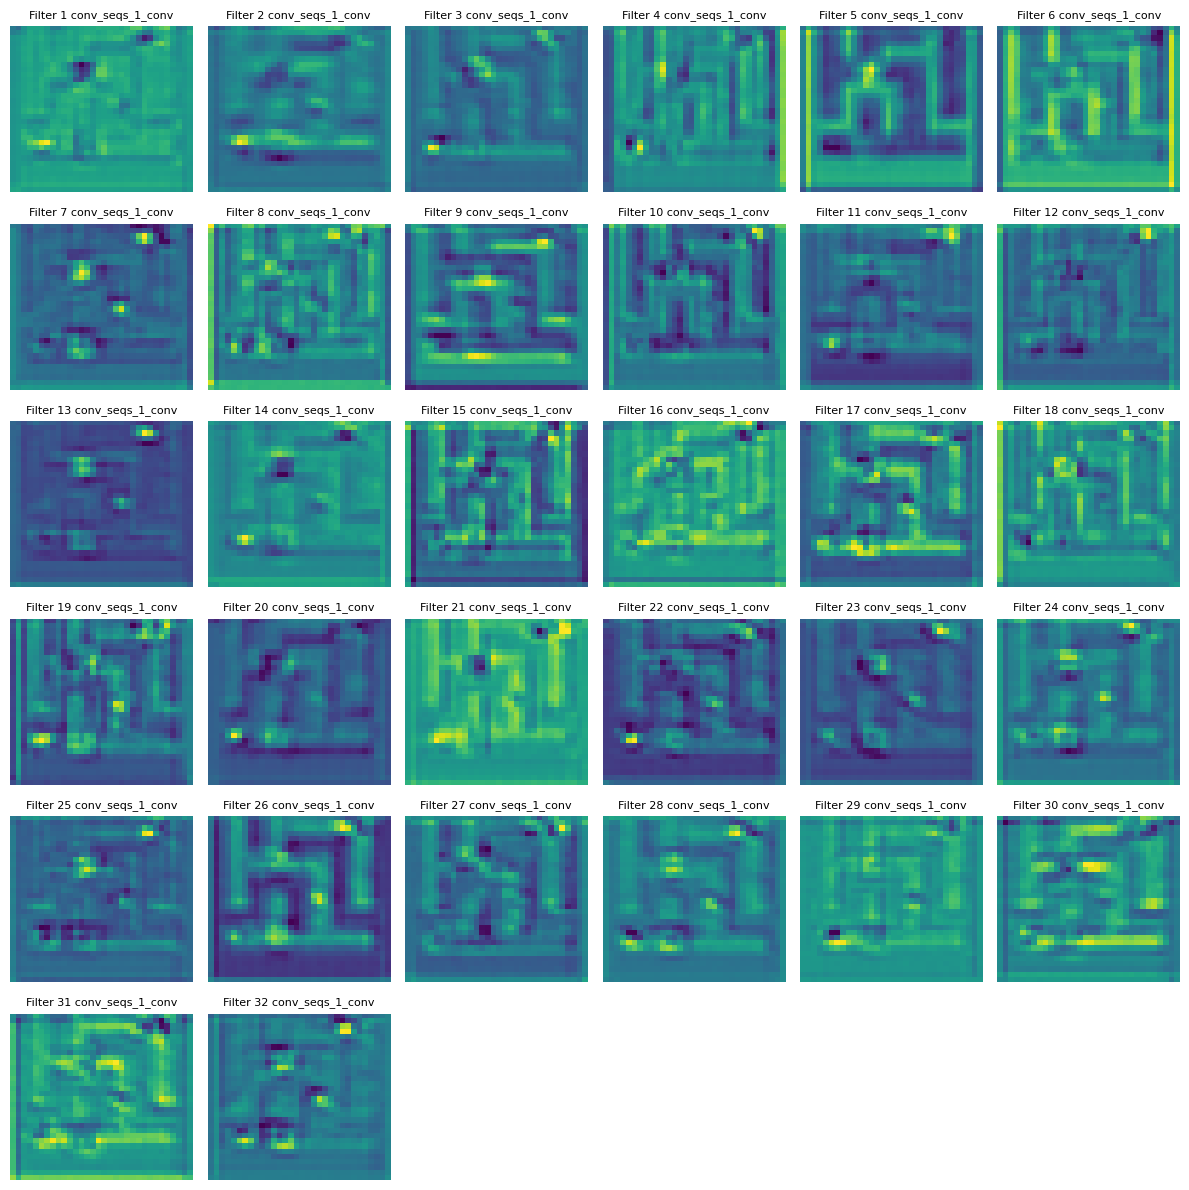

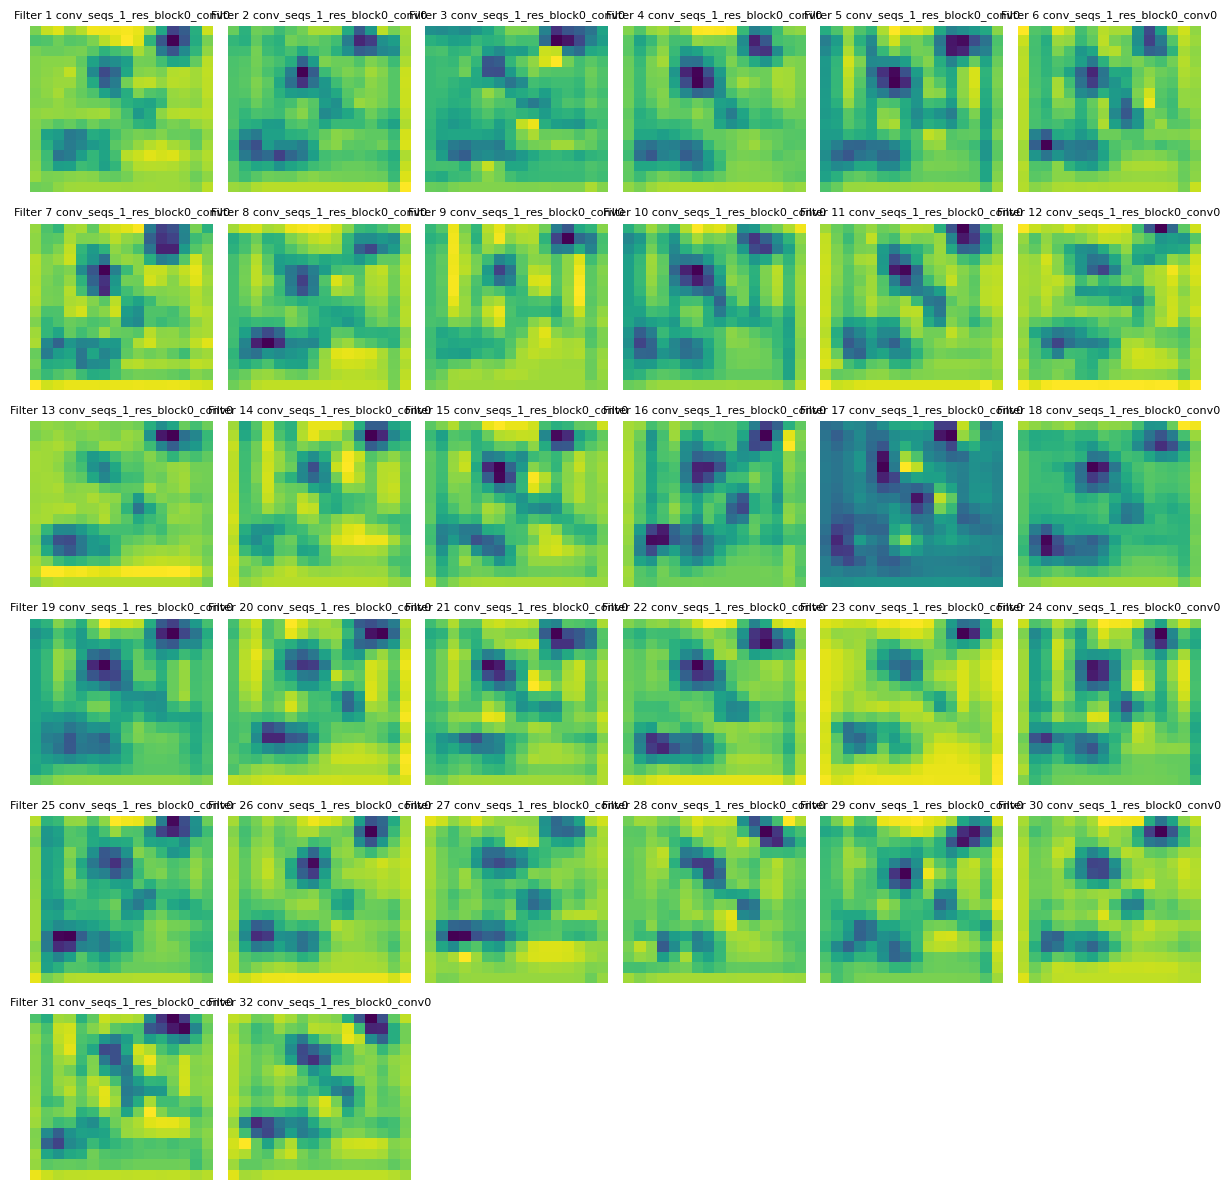

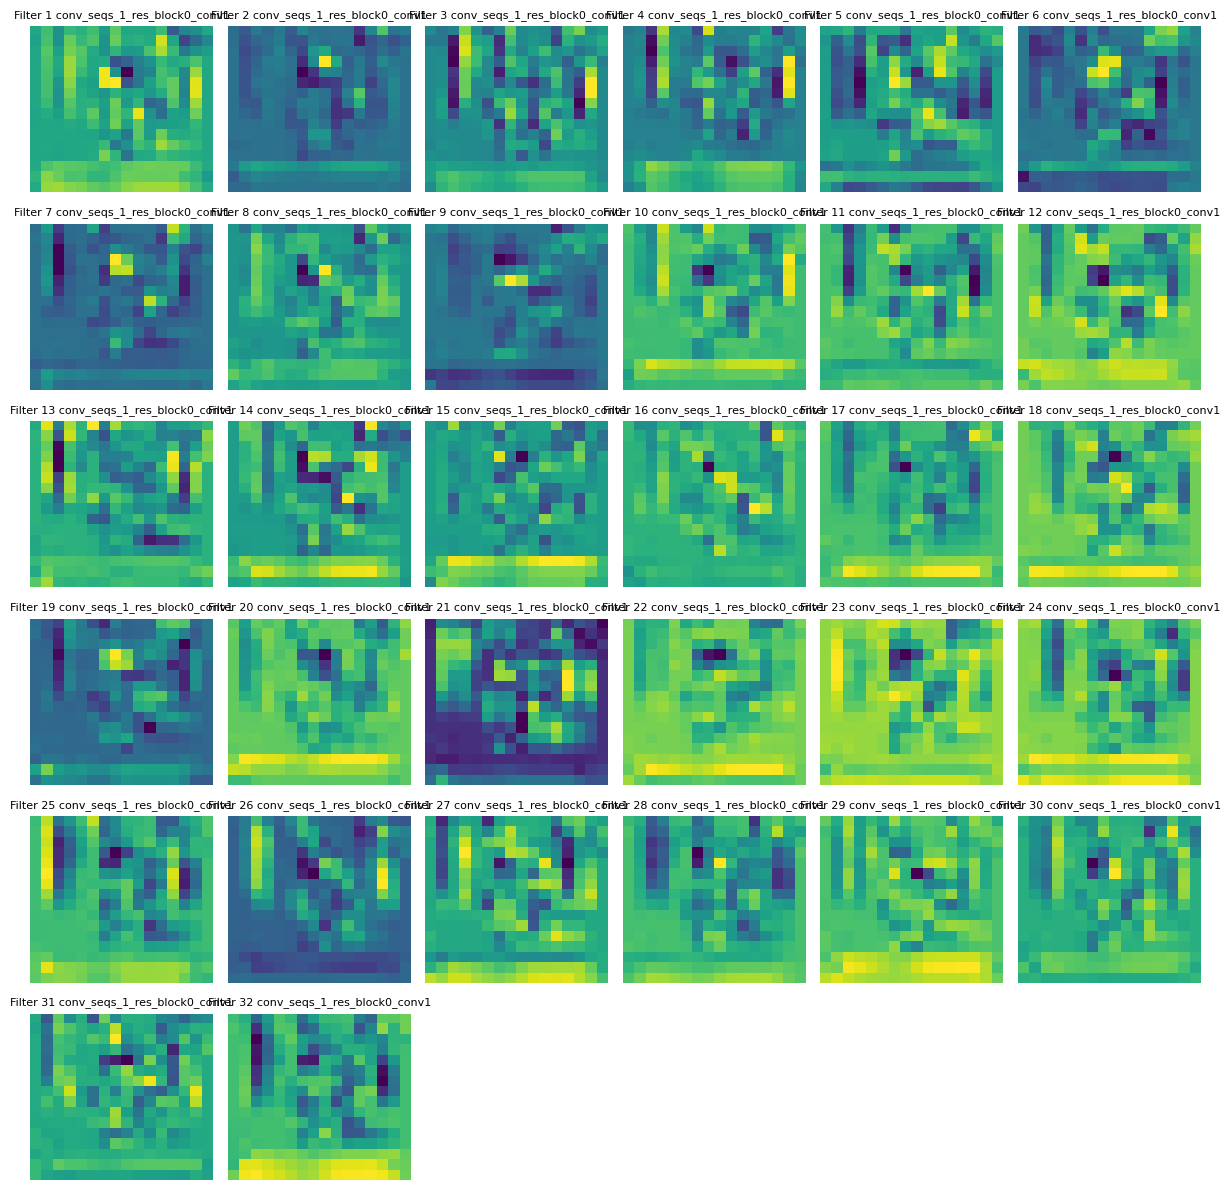

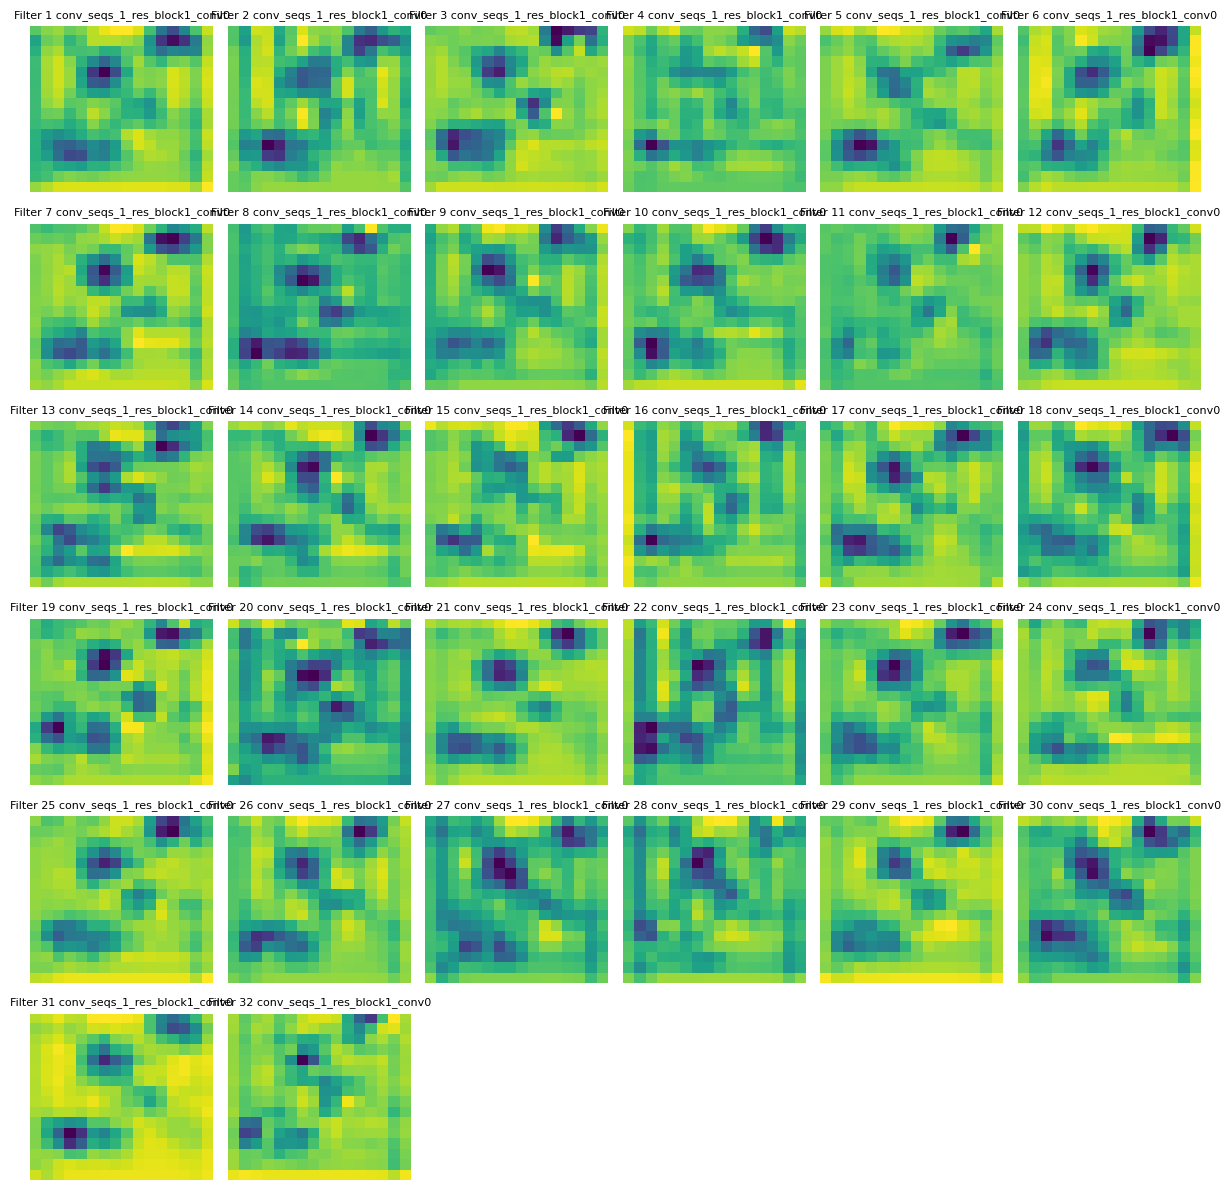

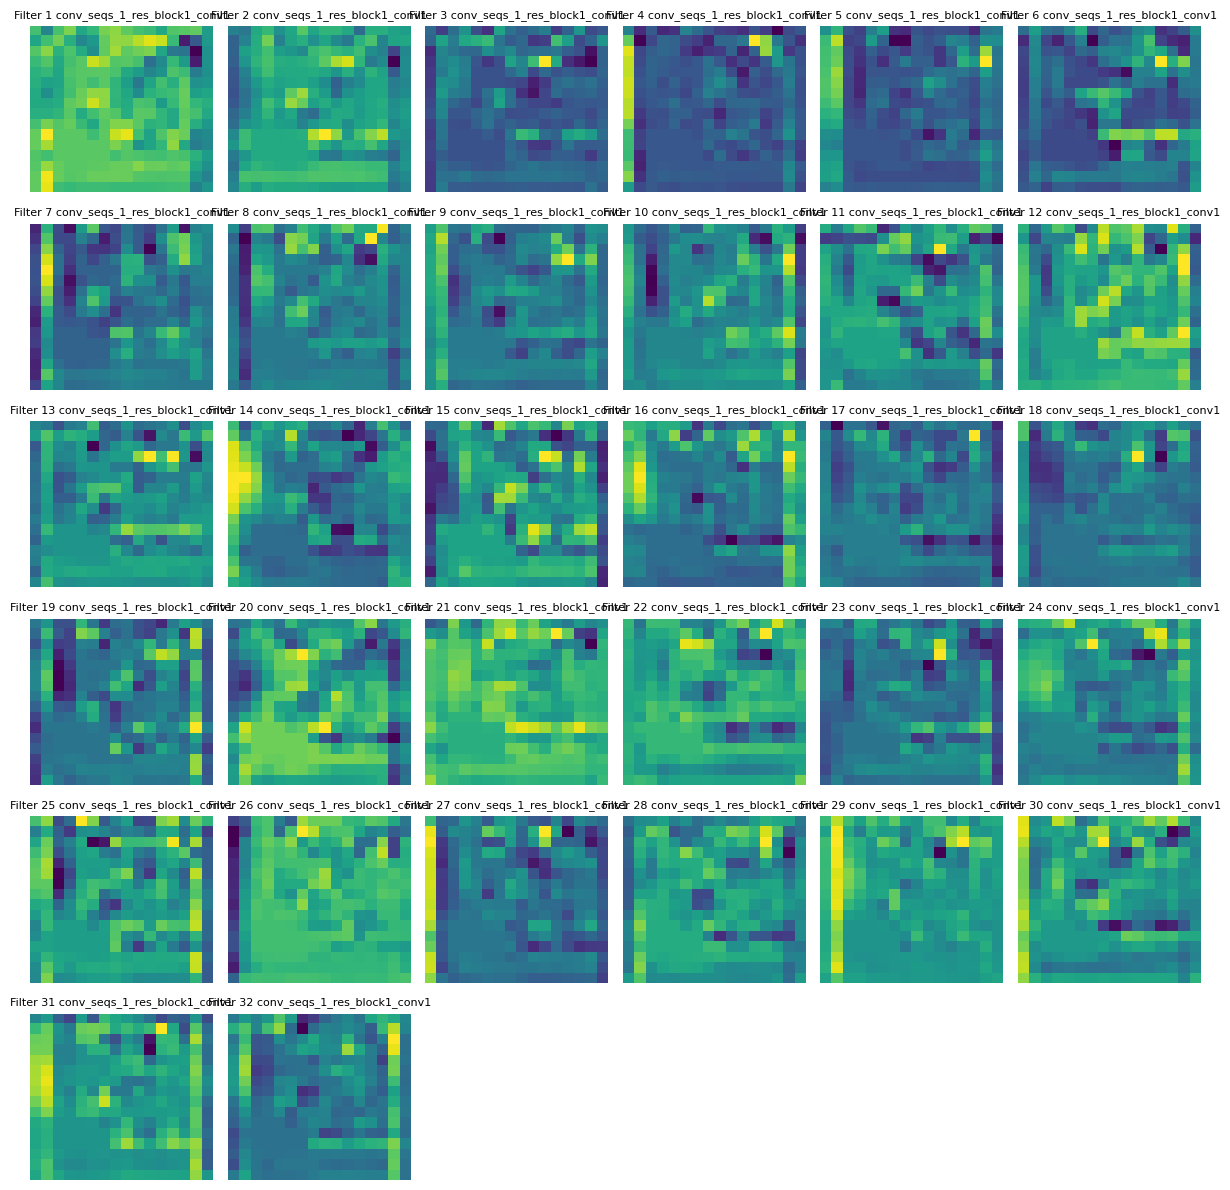

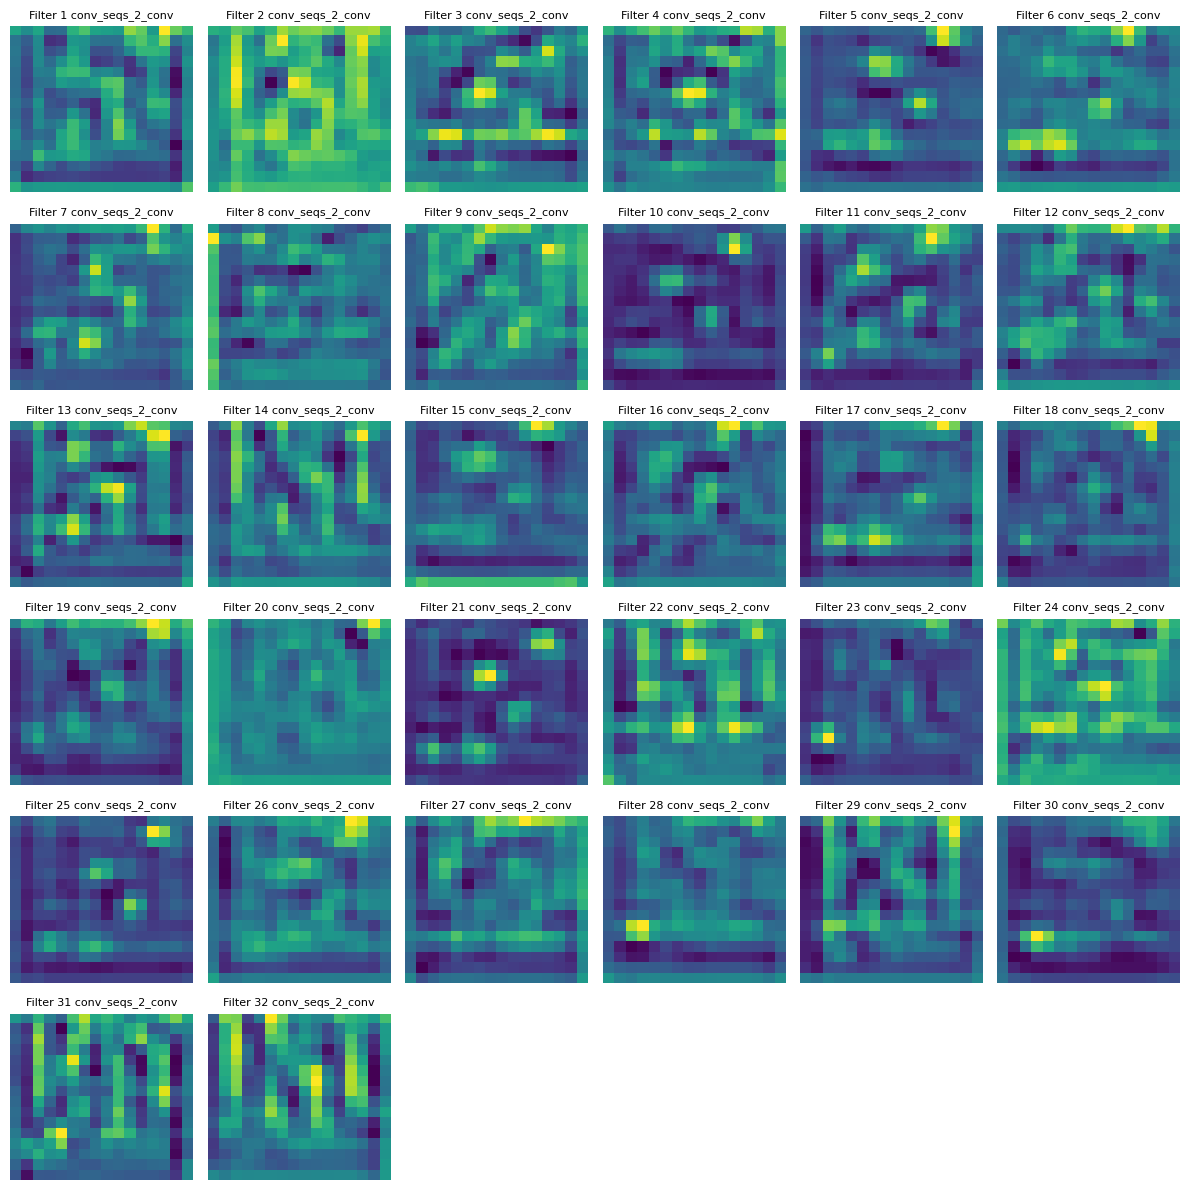

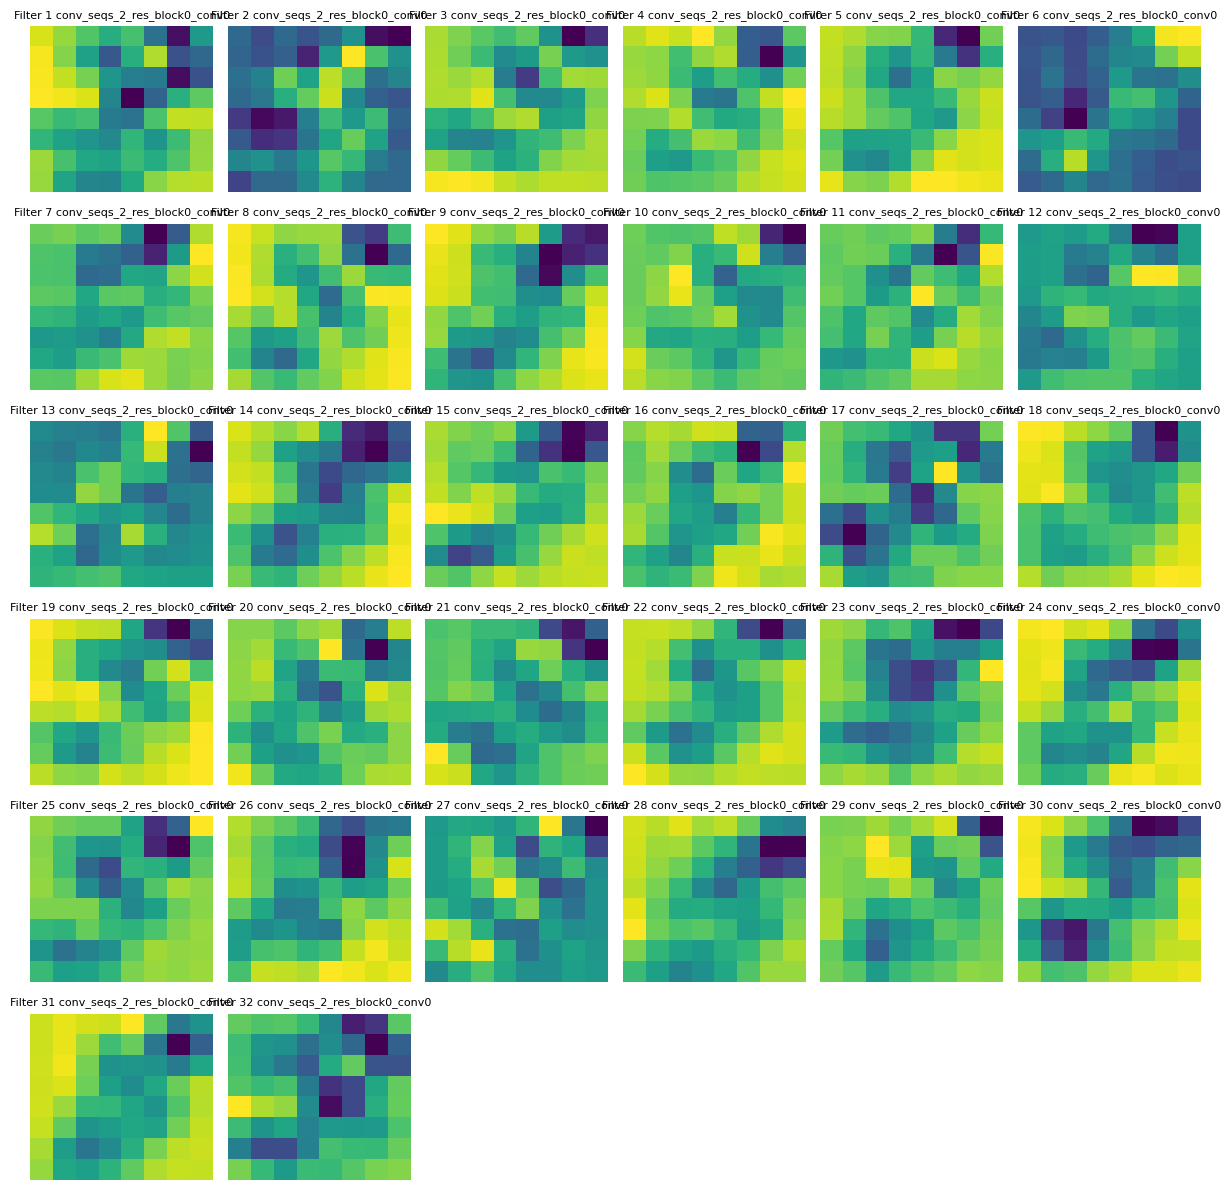

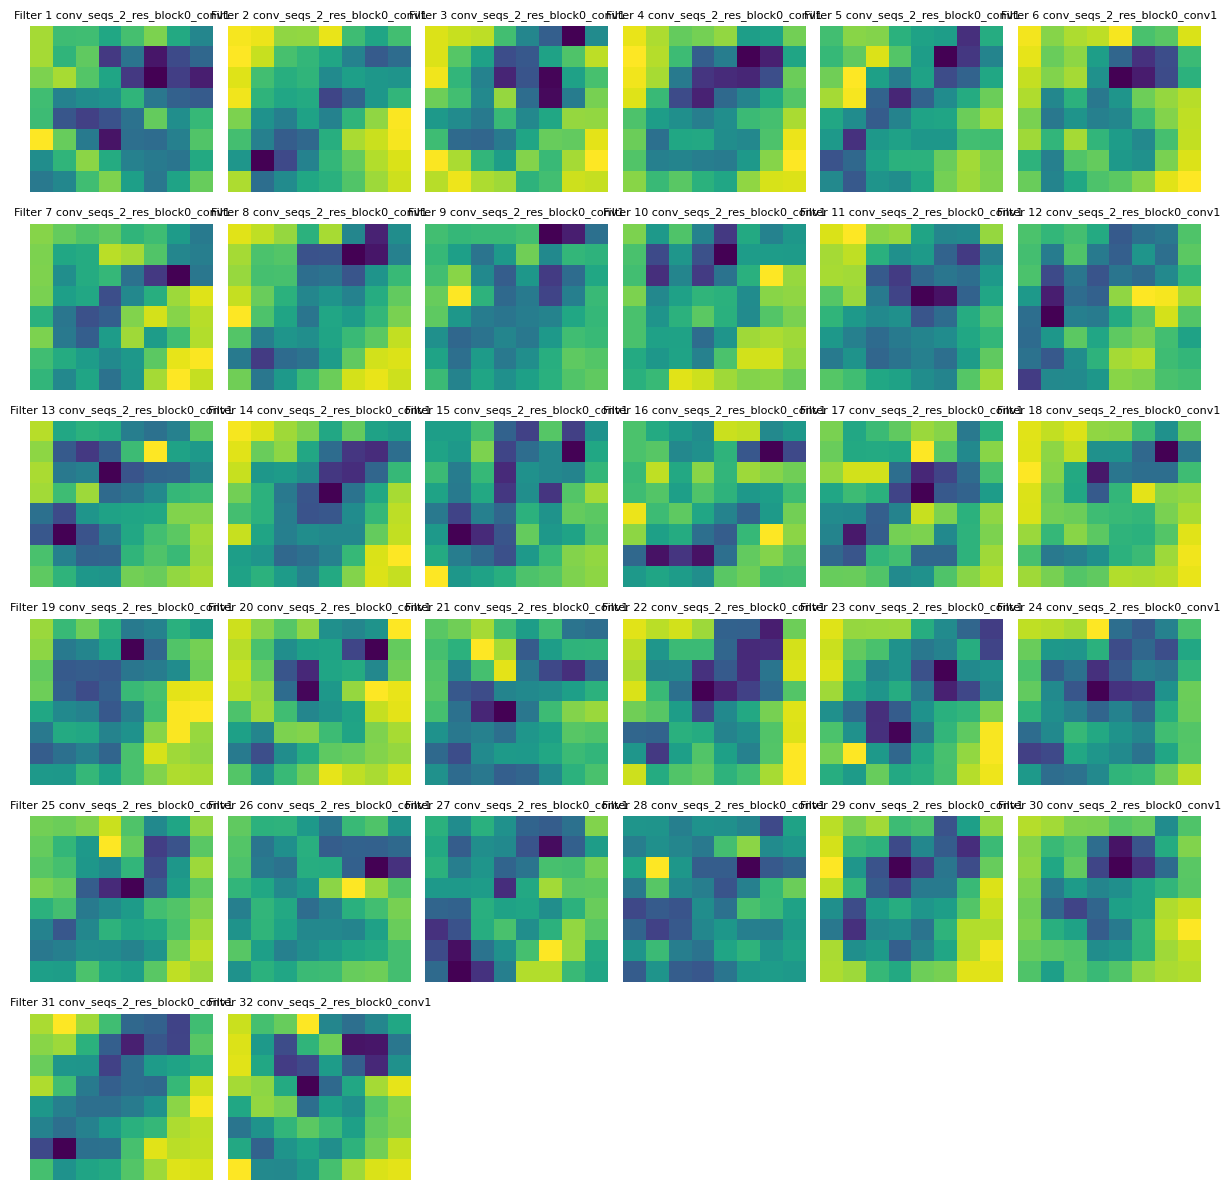

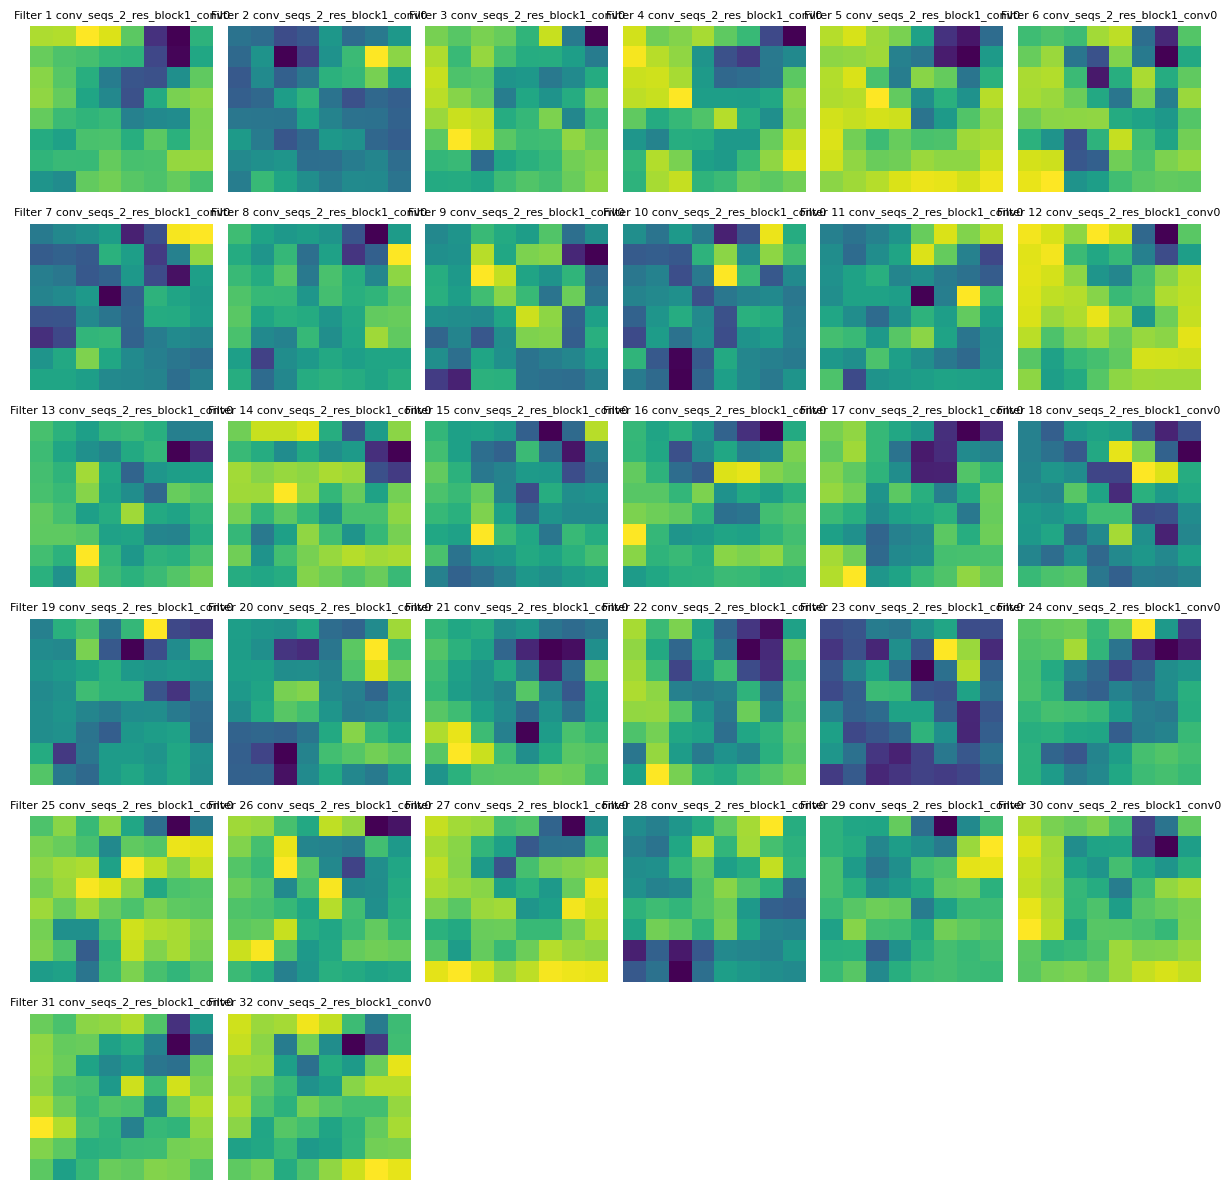

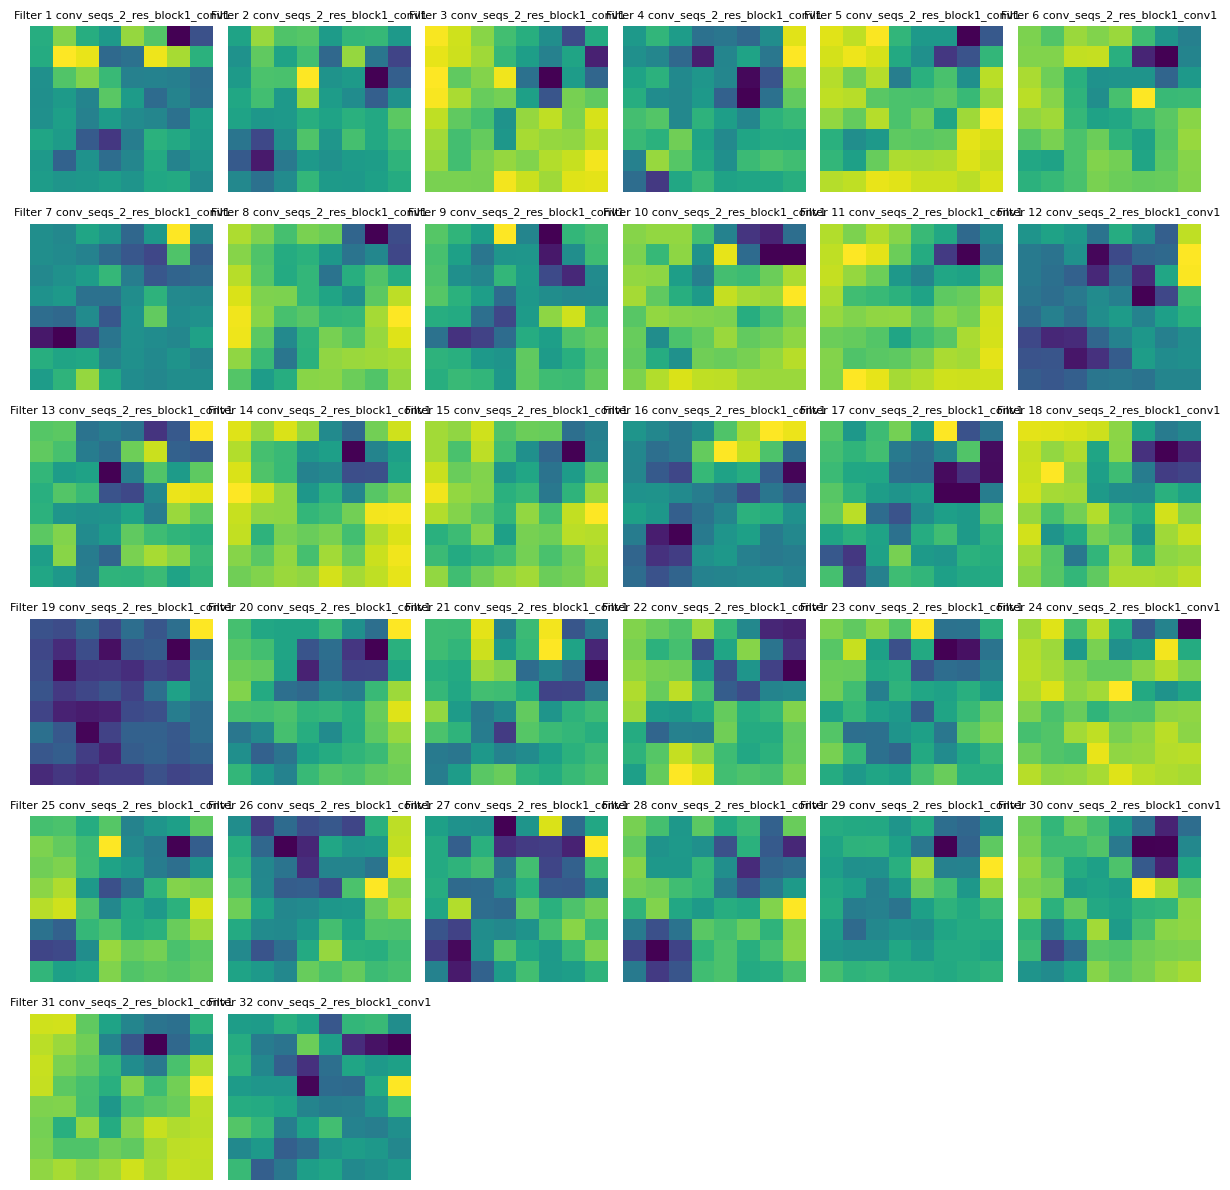

In [ ]:
plot_activations_for_layers(activations, layer_paths)

In [ ]:
differences.keys()


dict_keys(['conv_seqs_0_conv', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_1_conv', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1'])

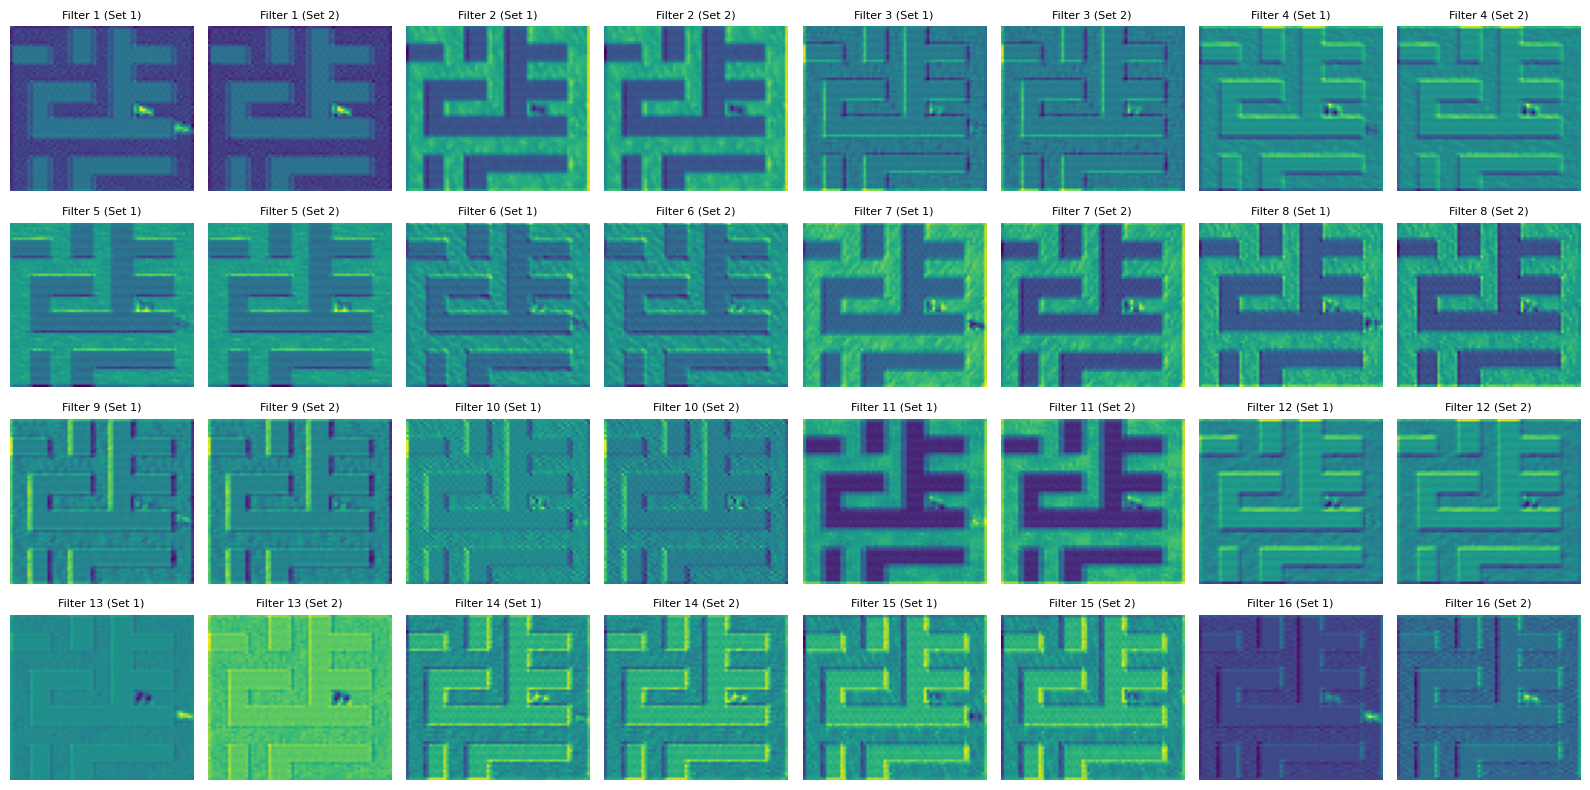

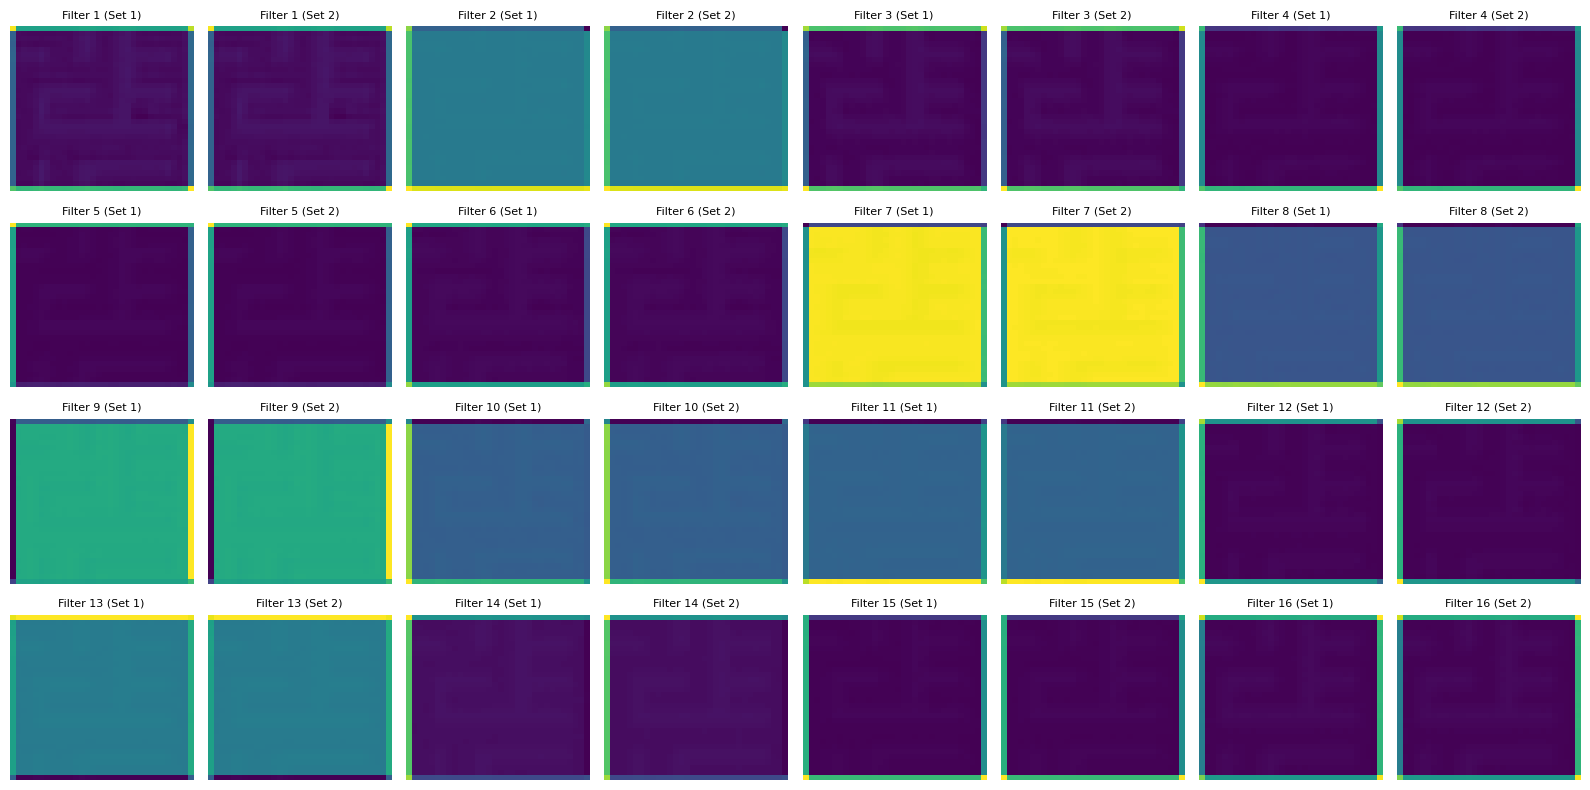

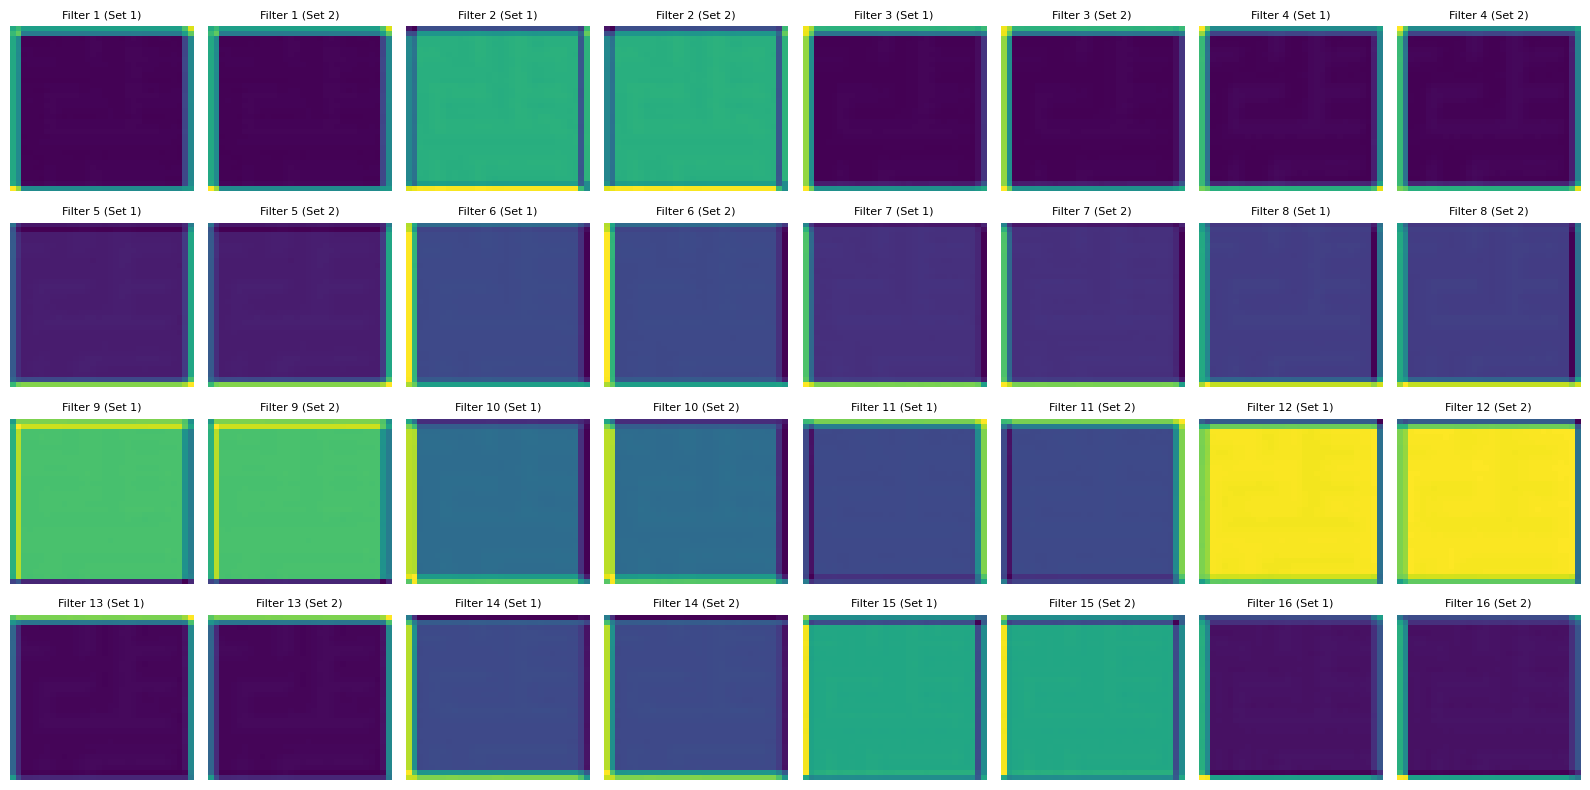

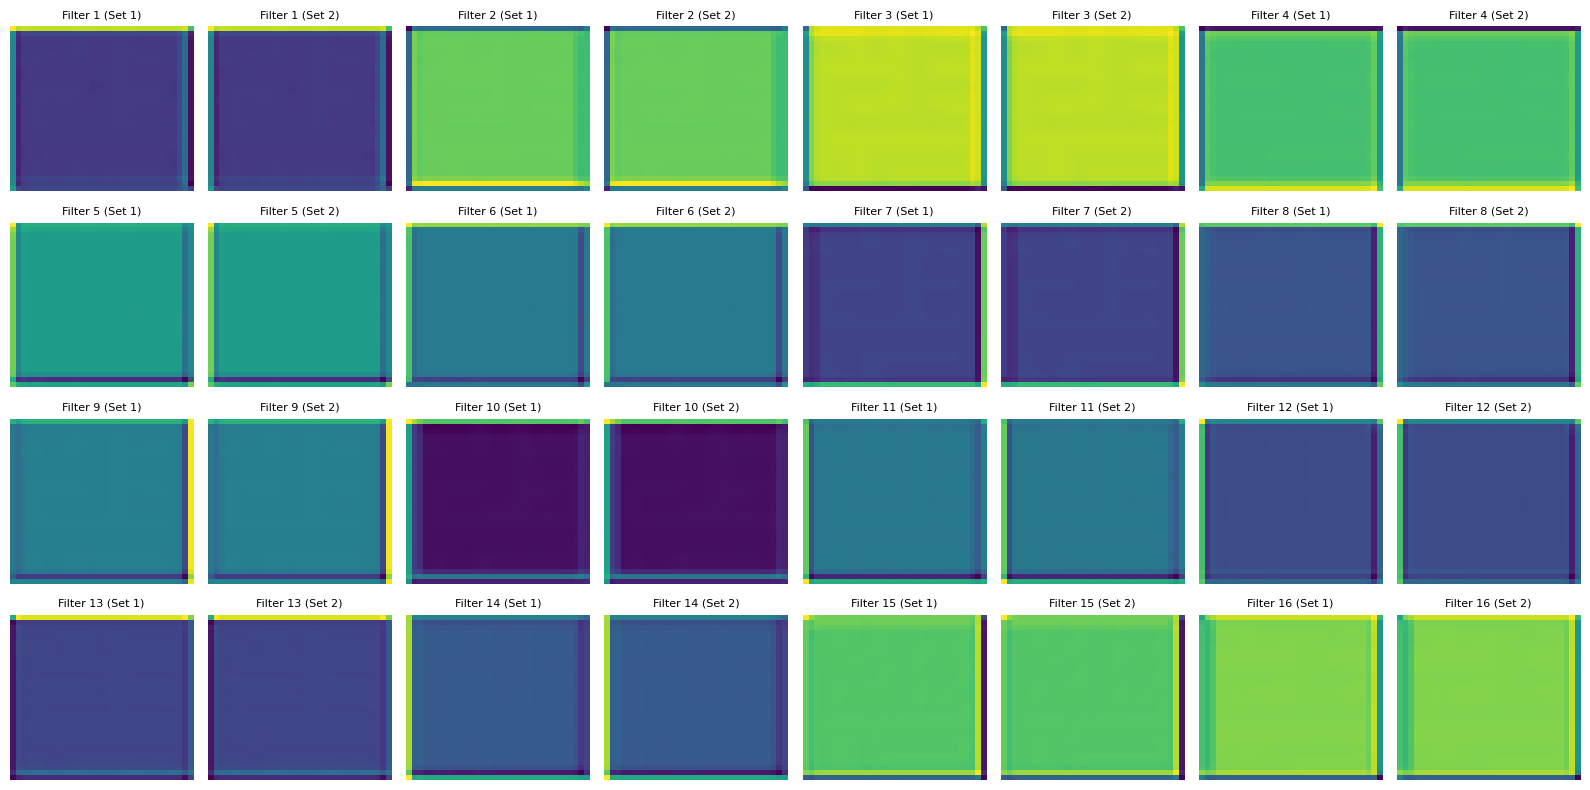

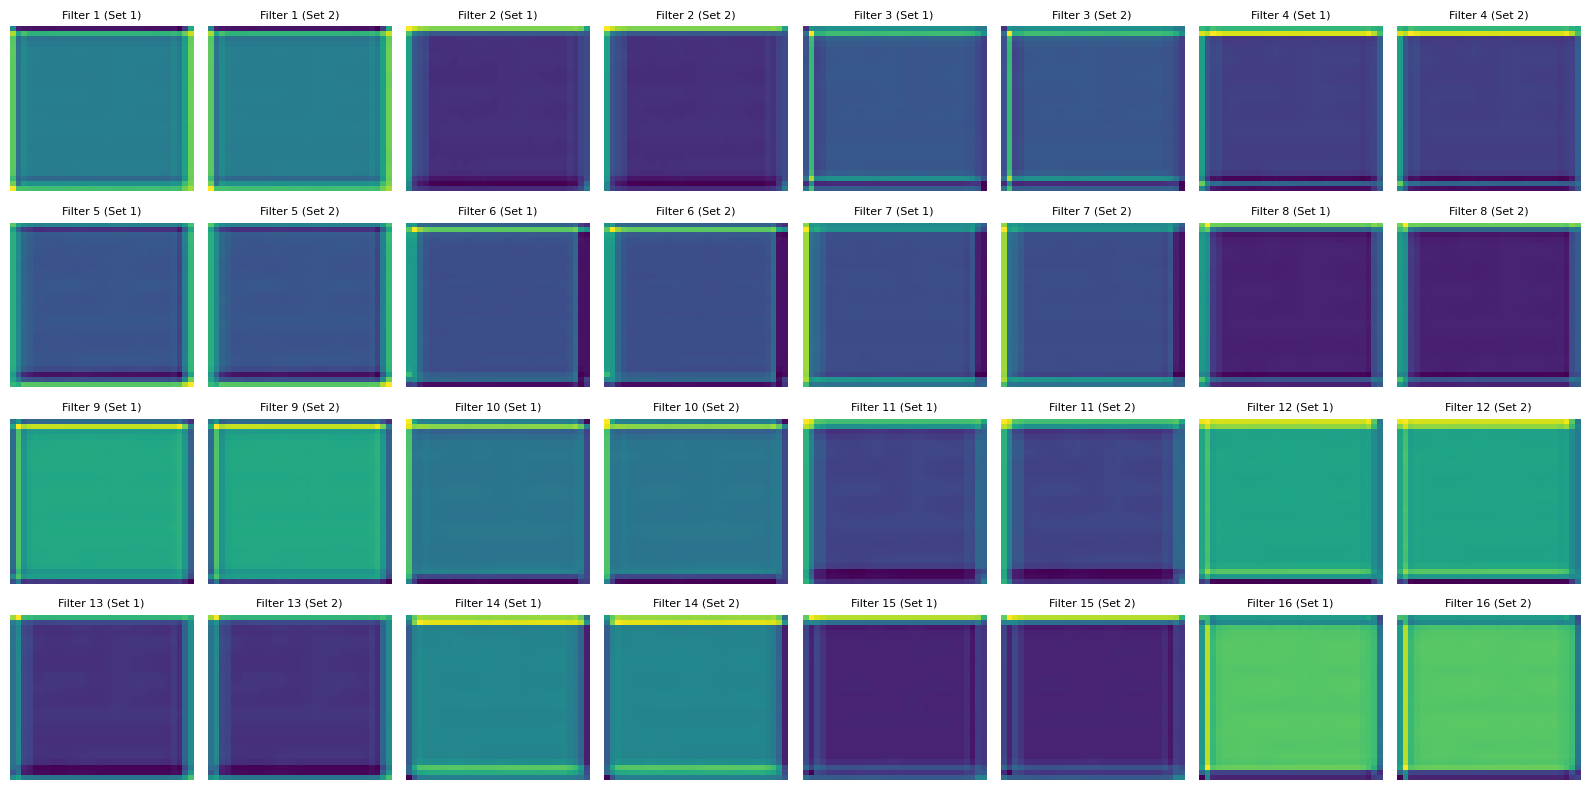

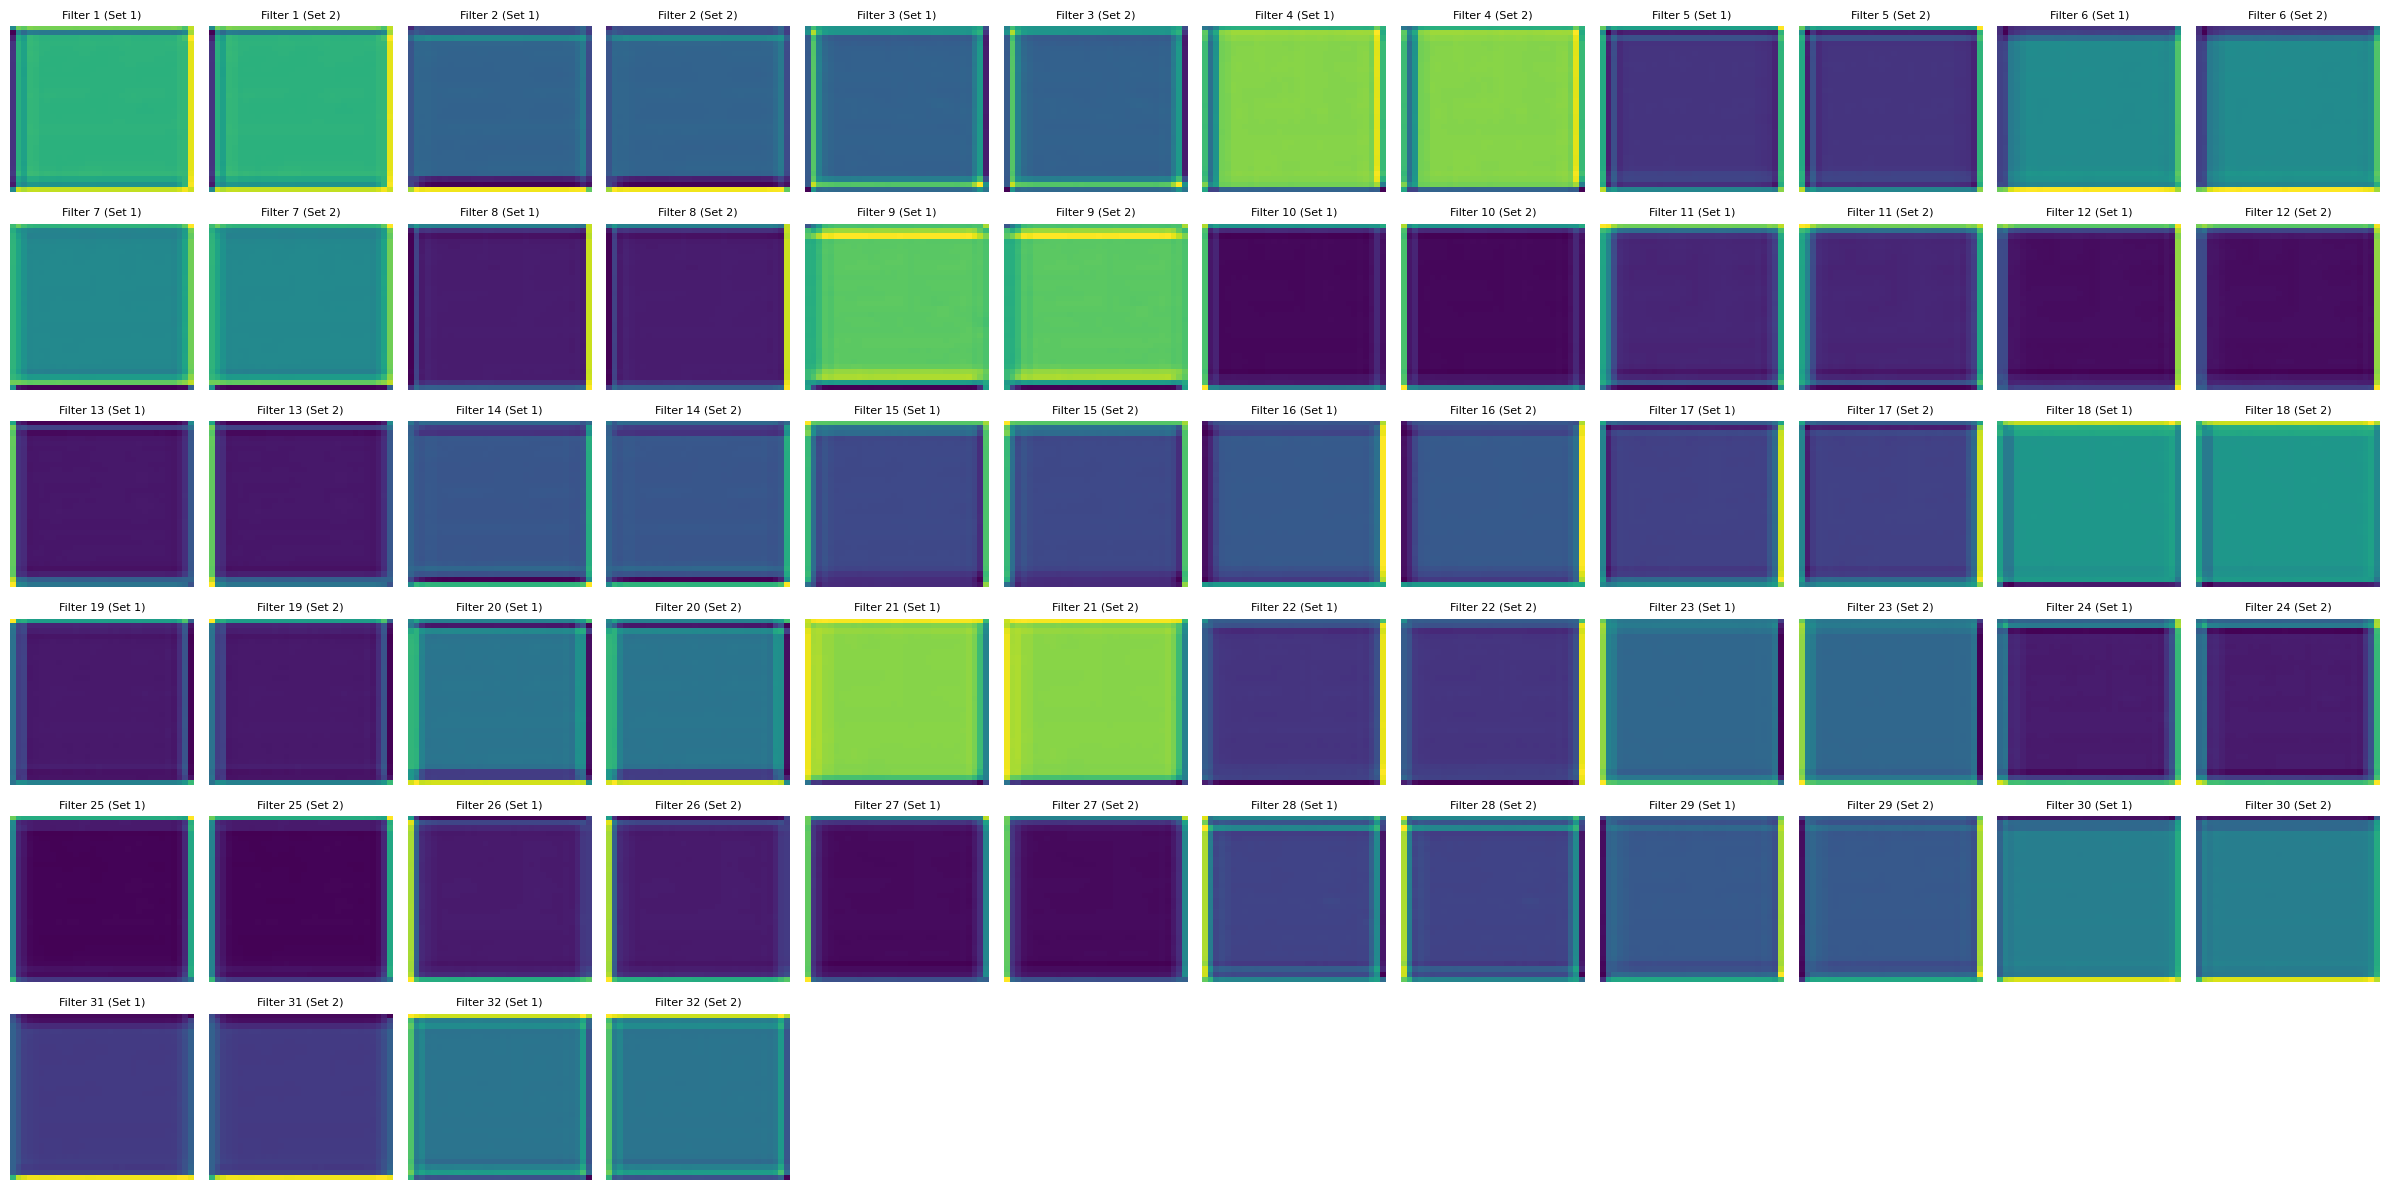

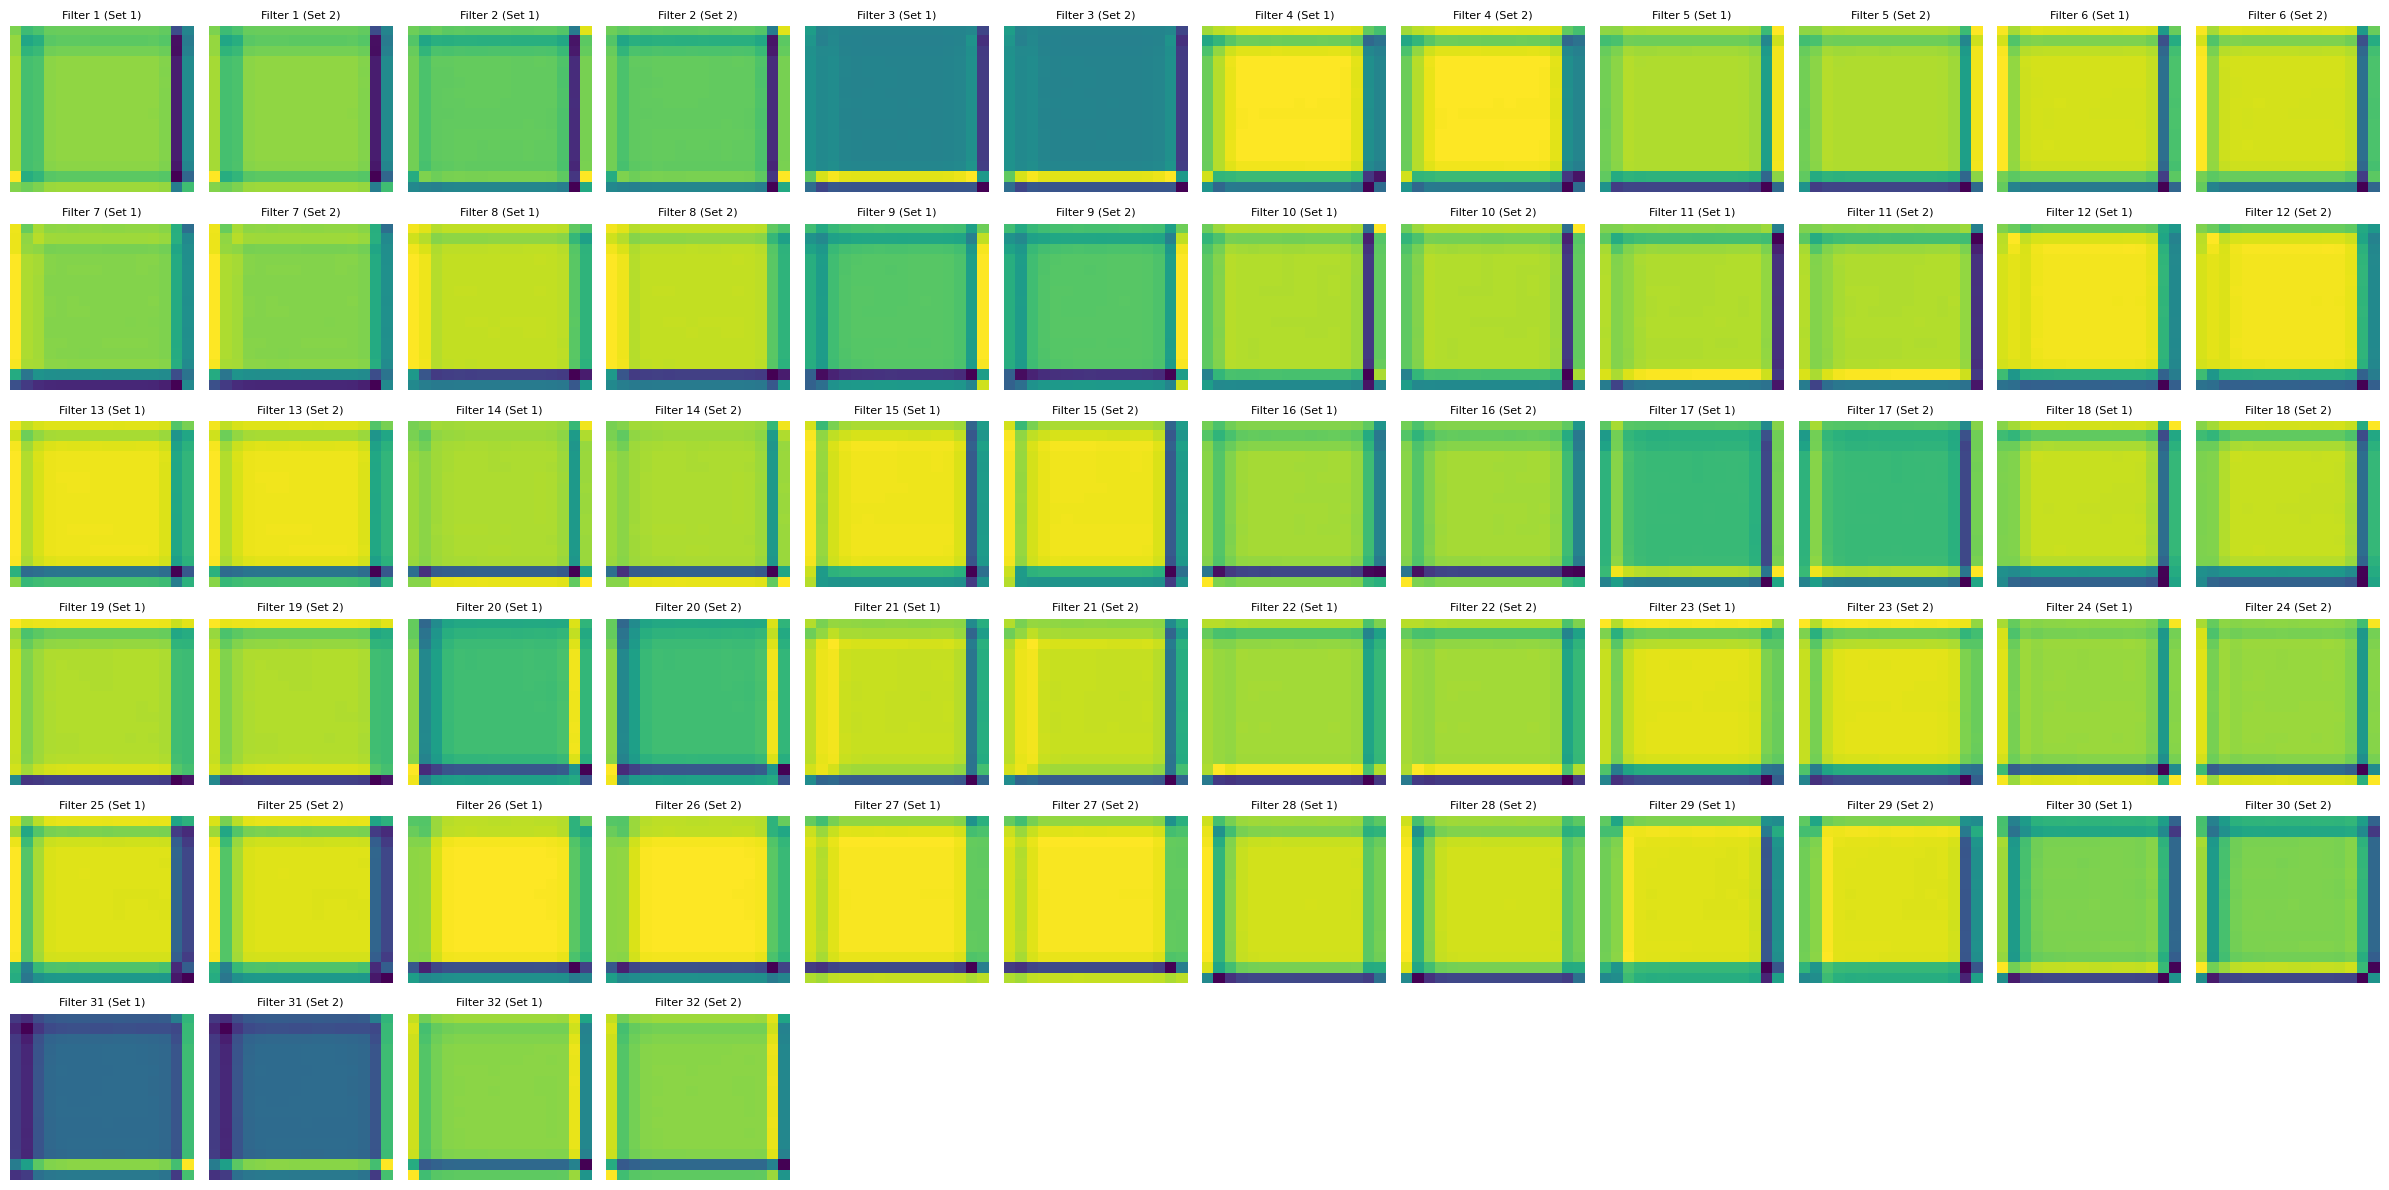

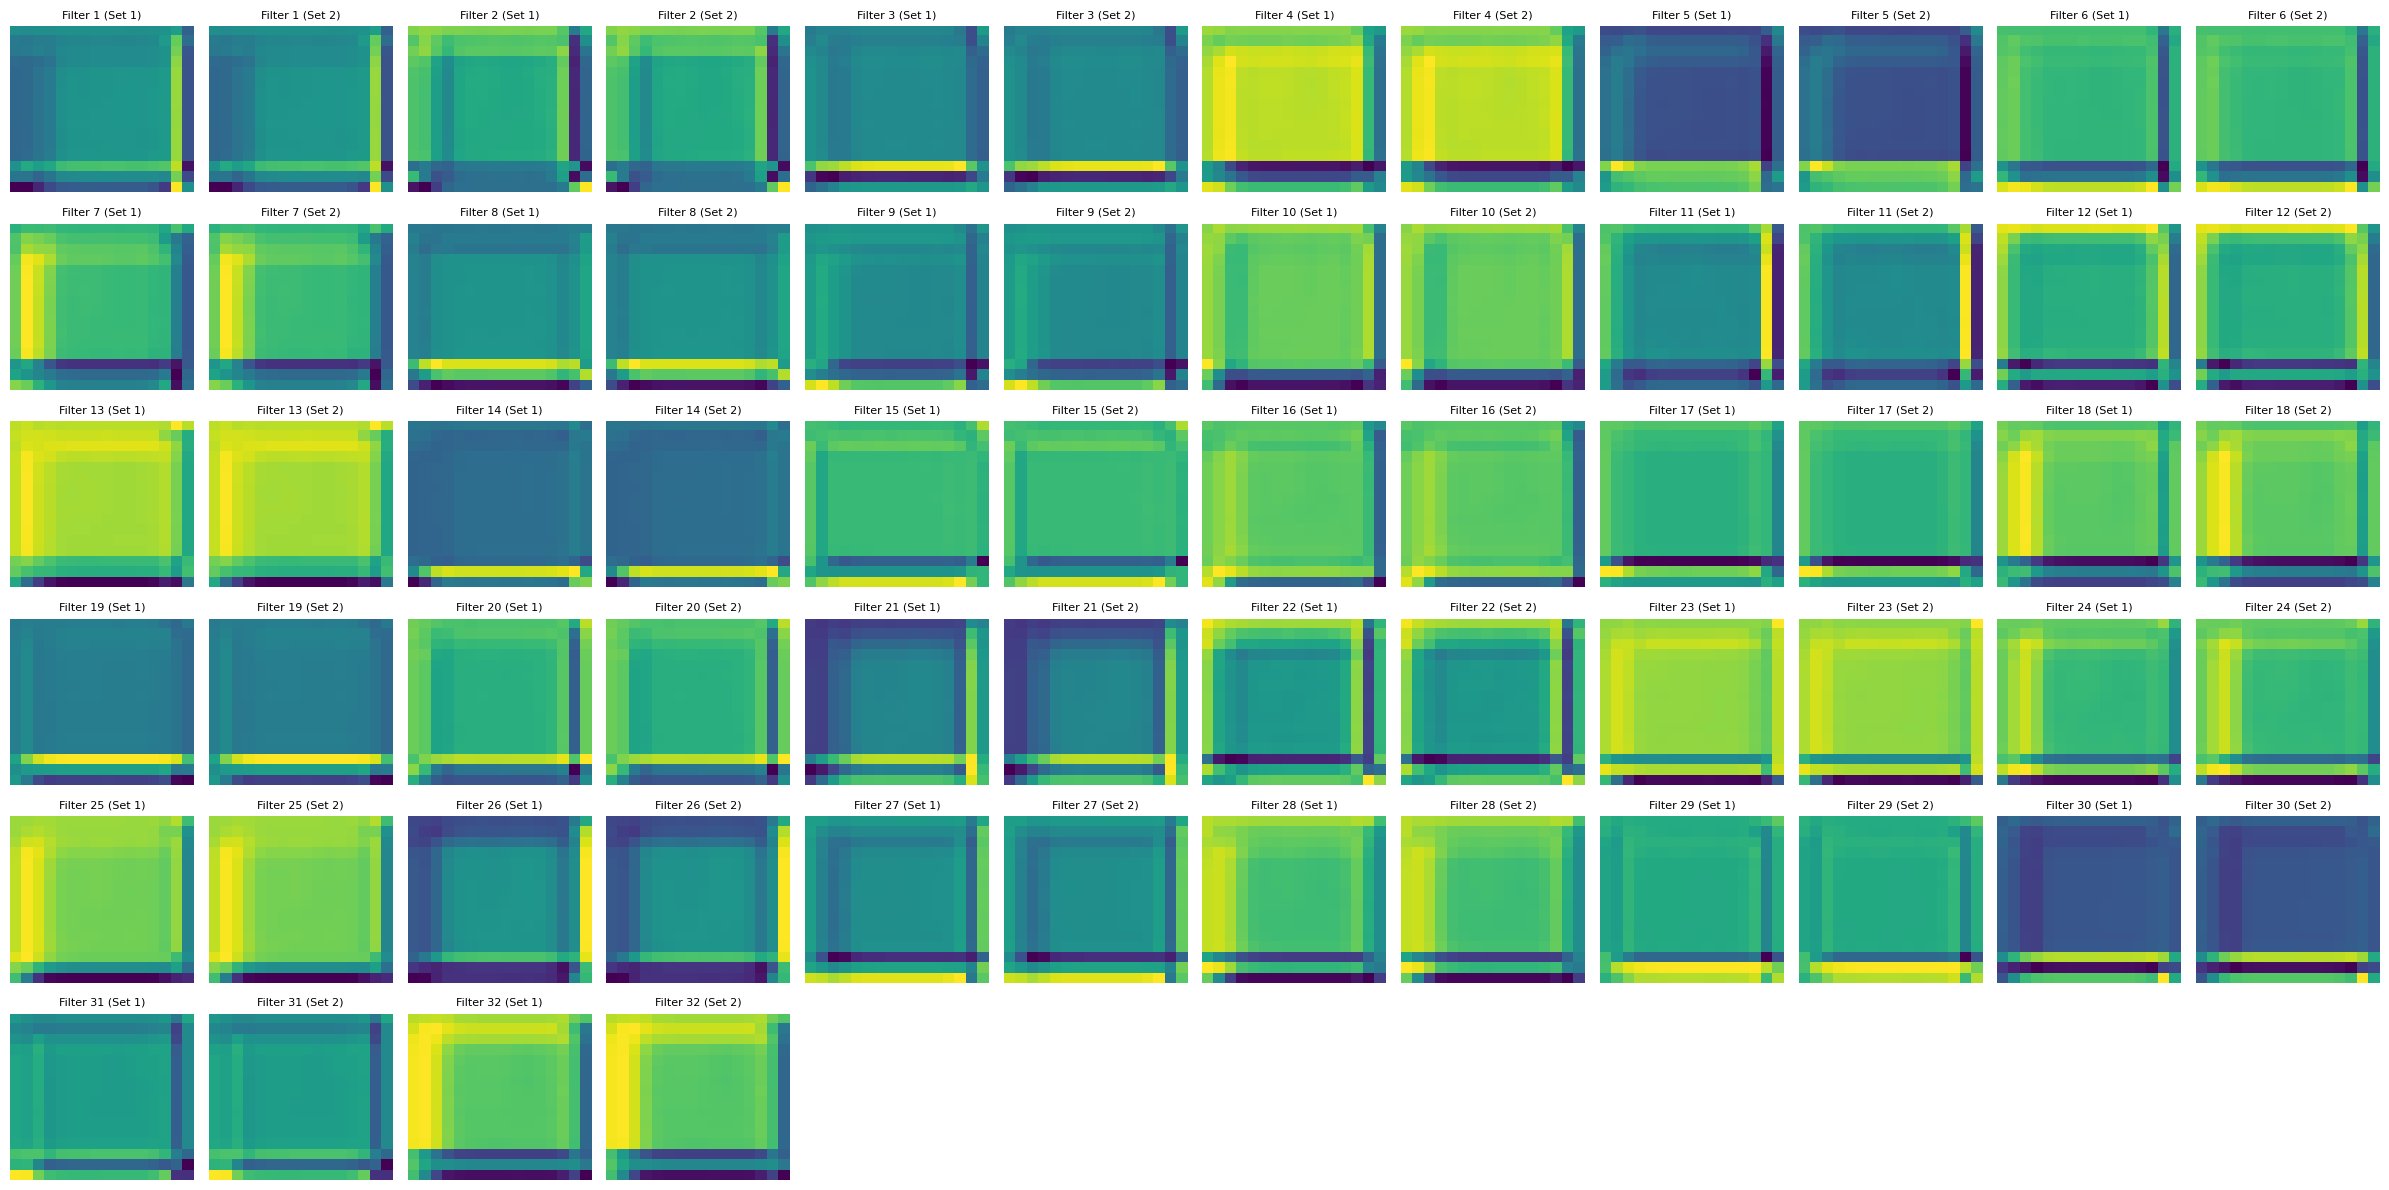

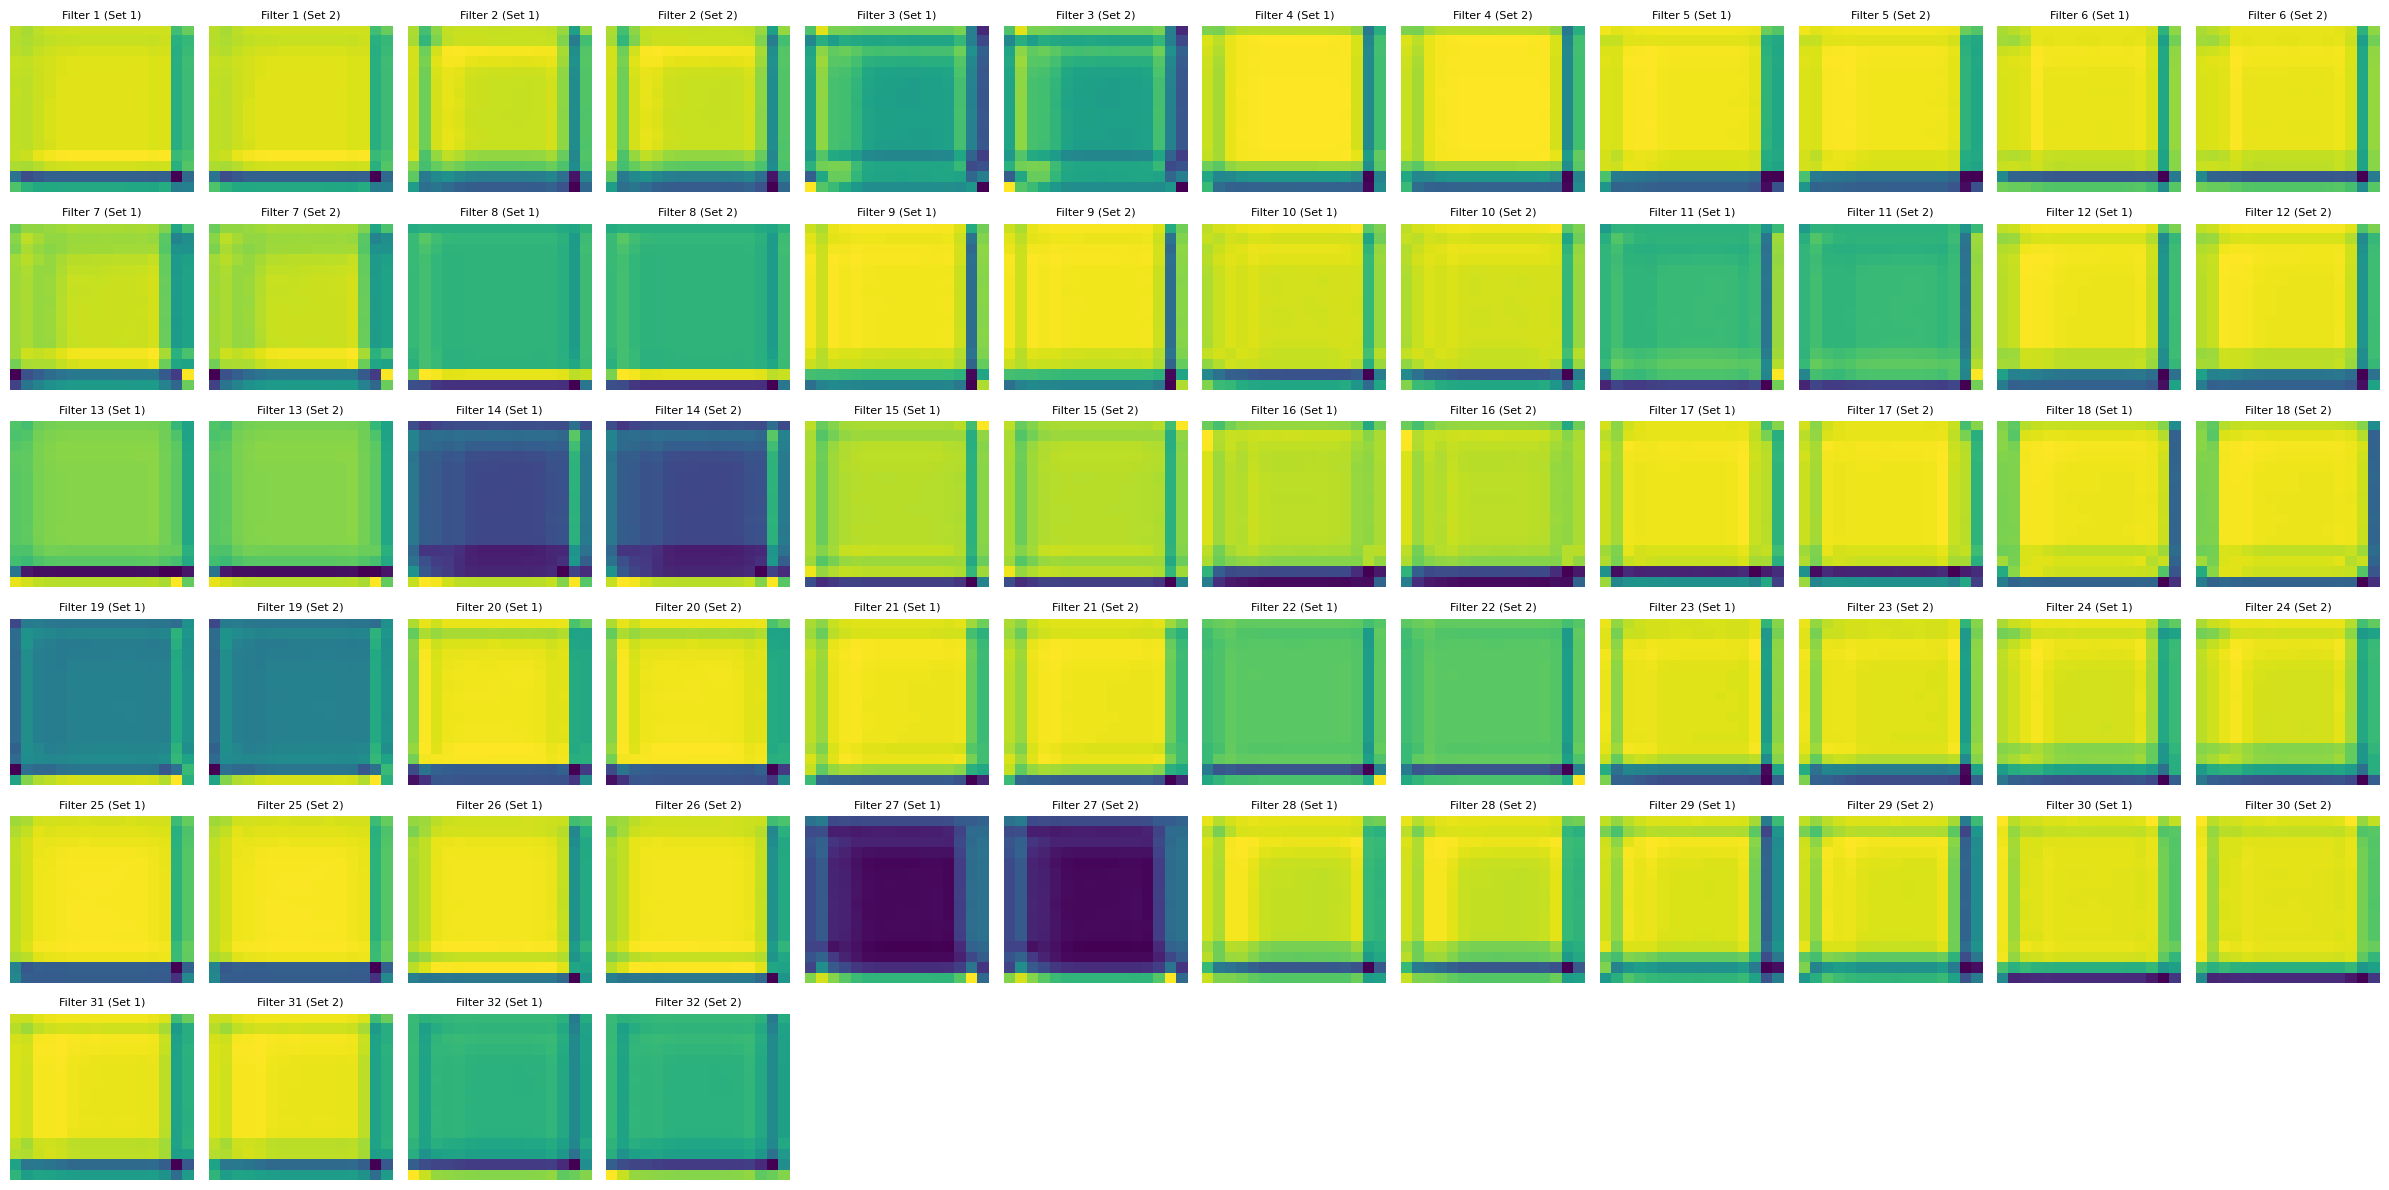

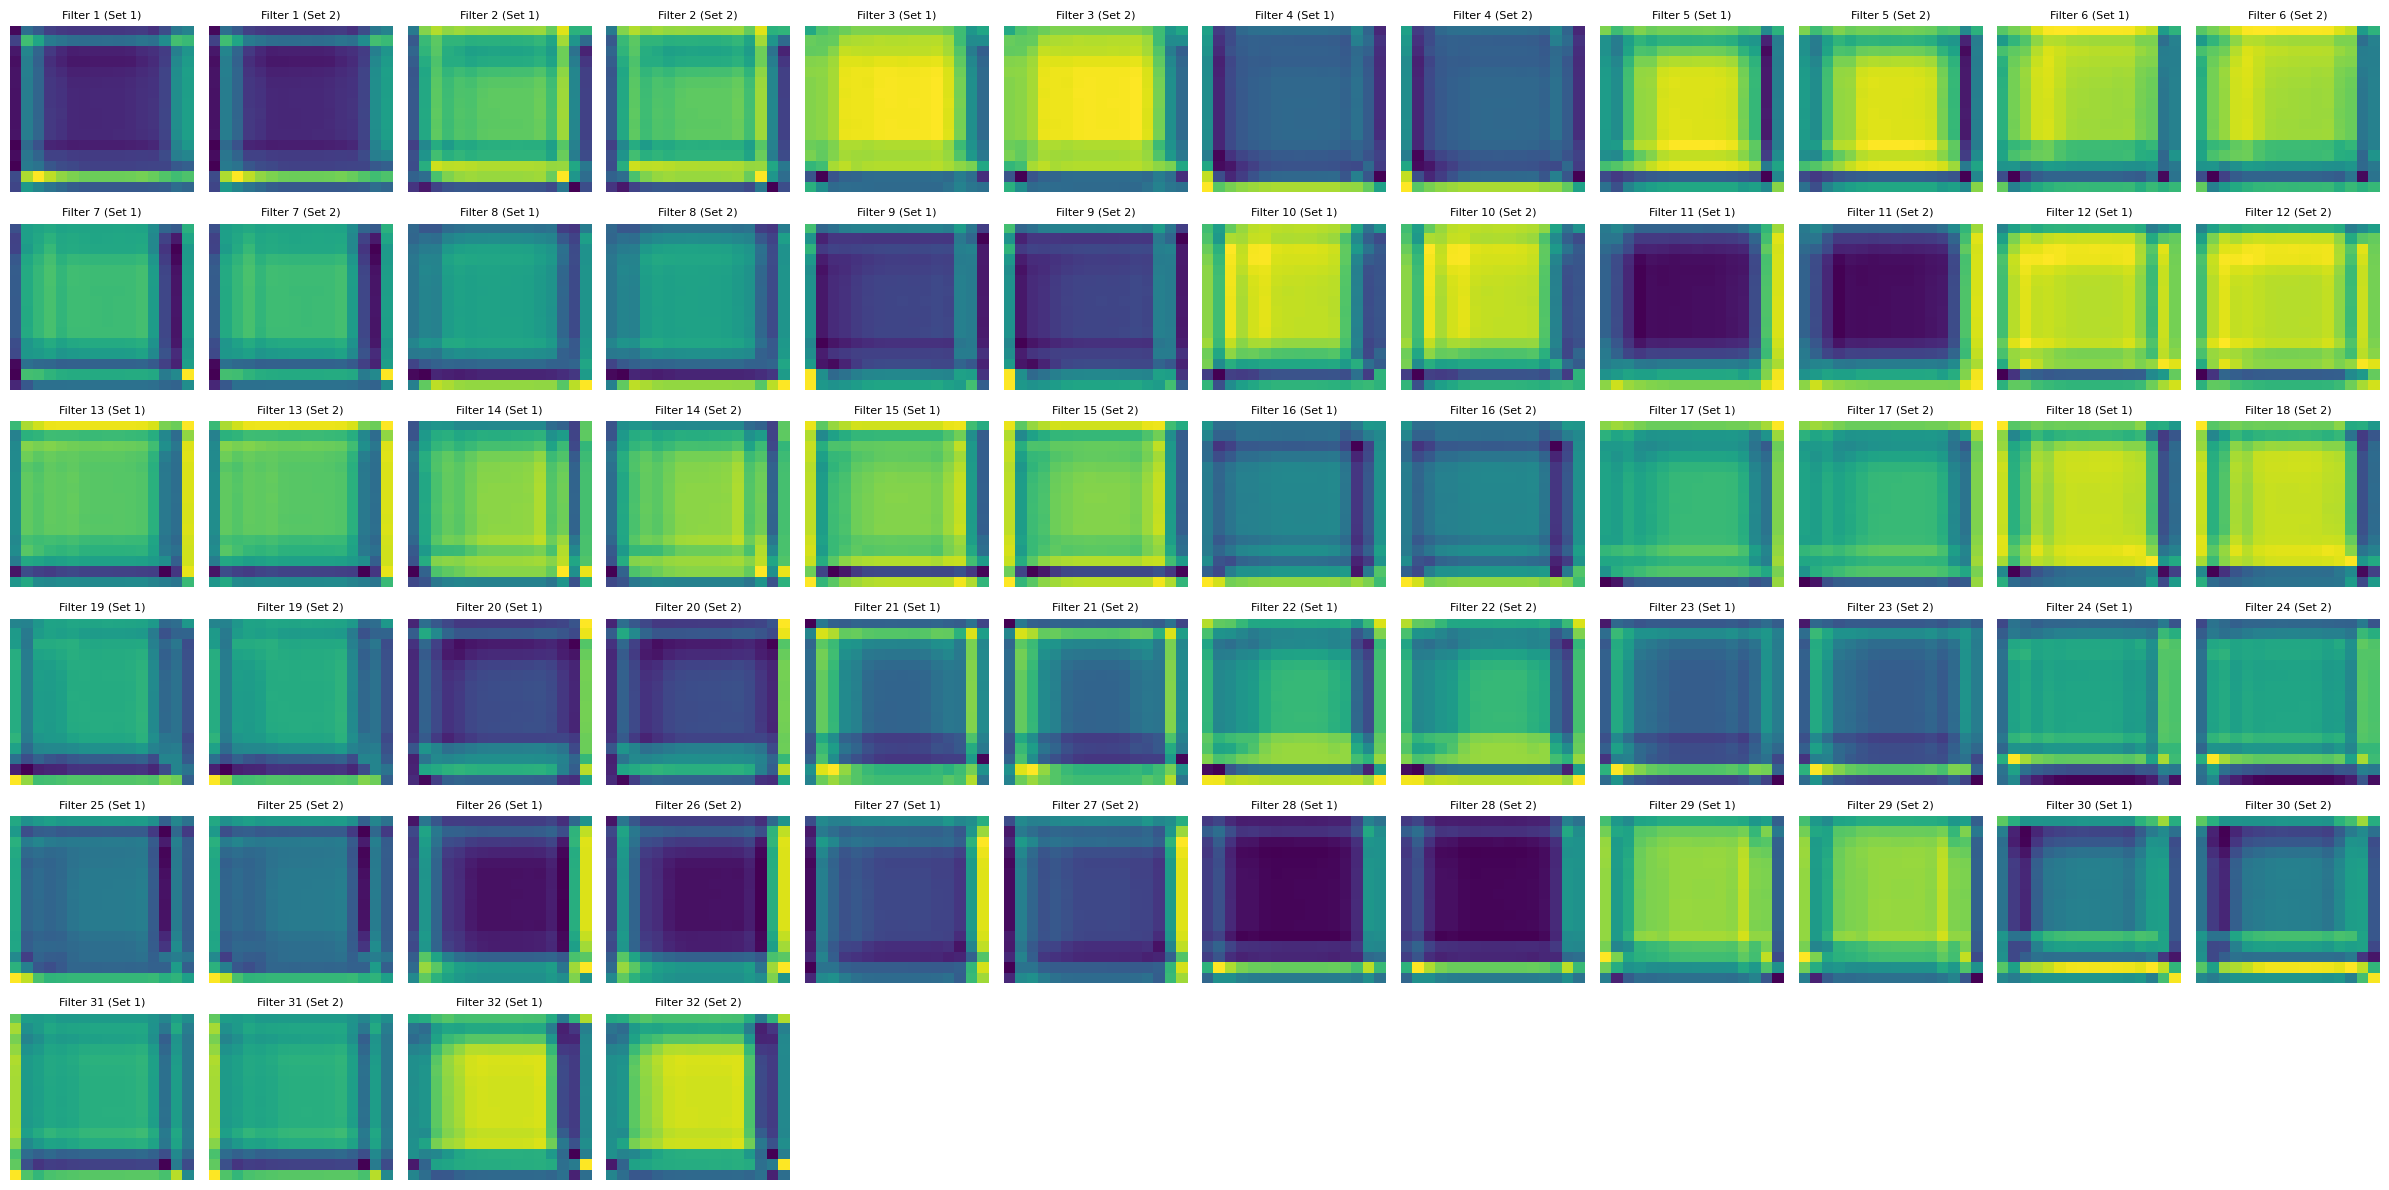

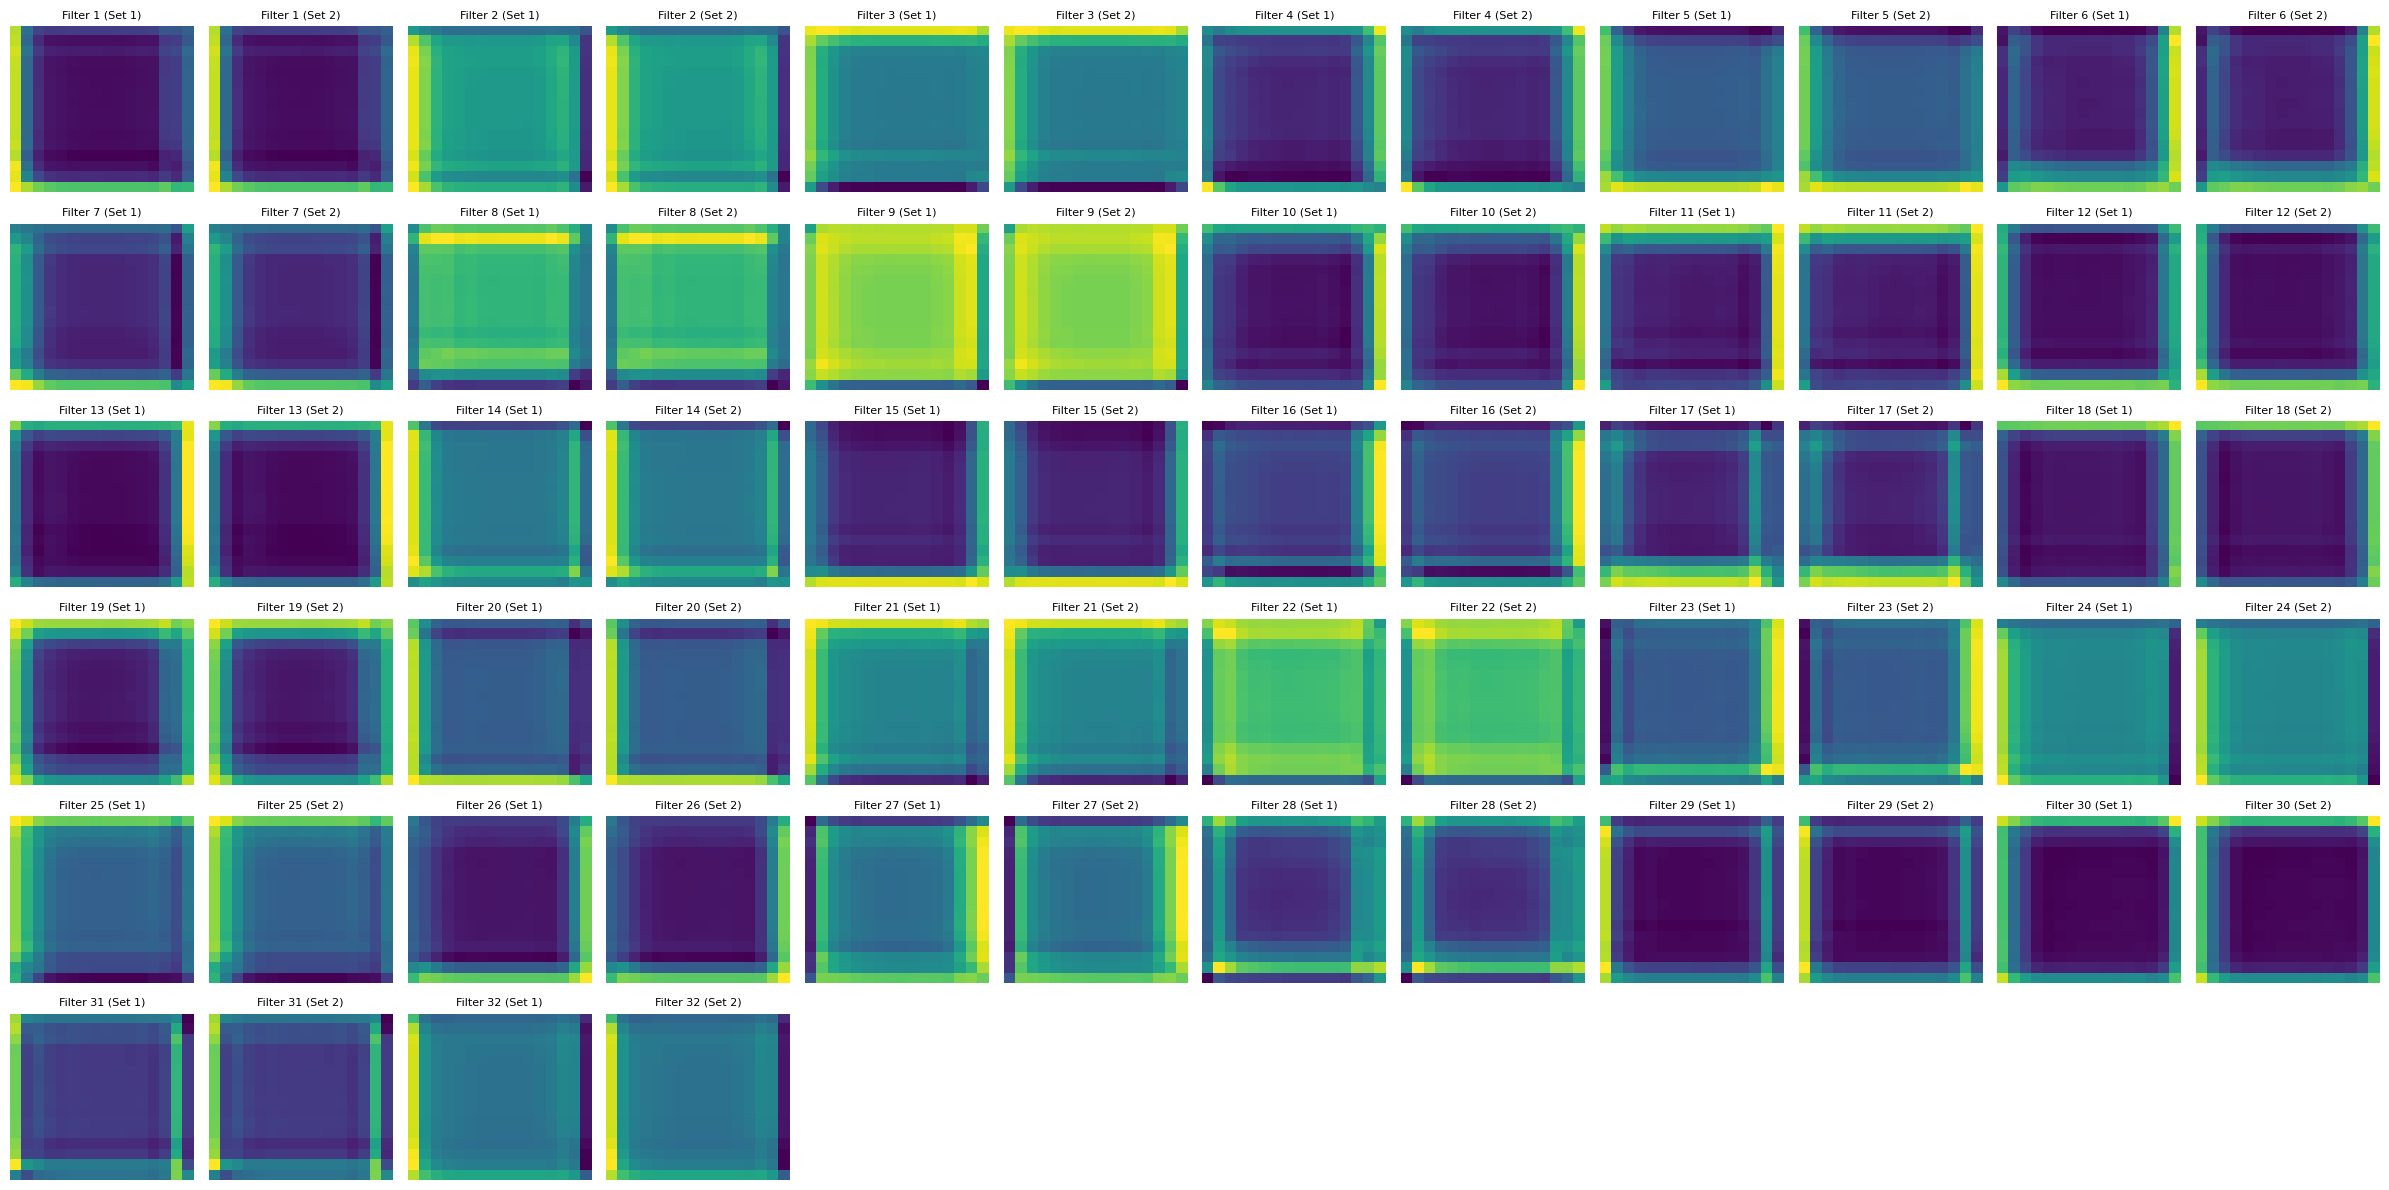

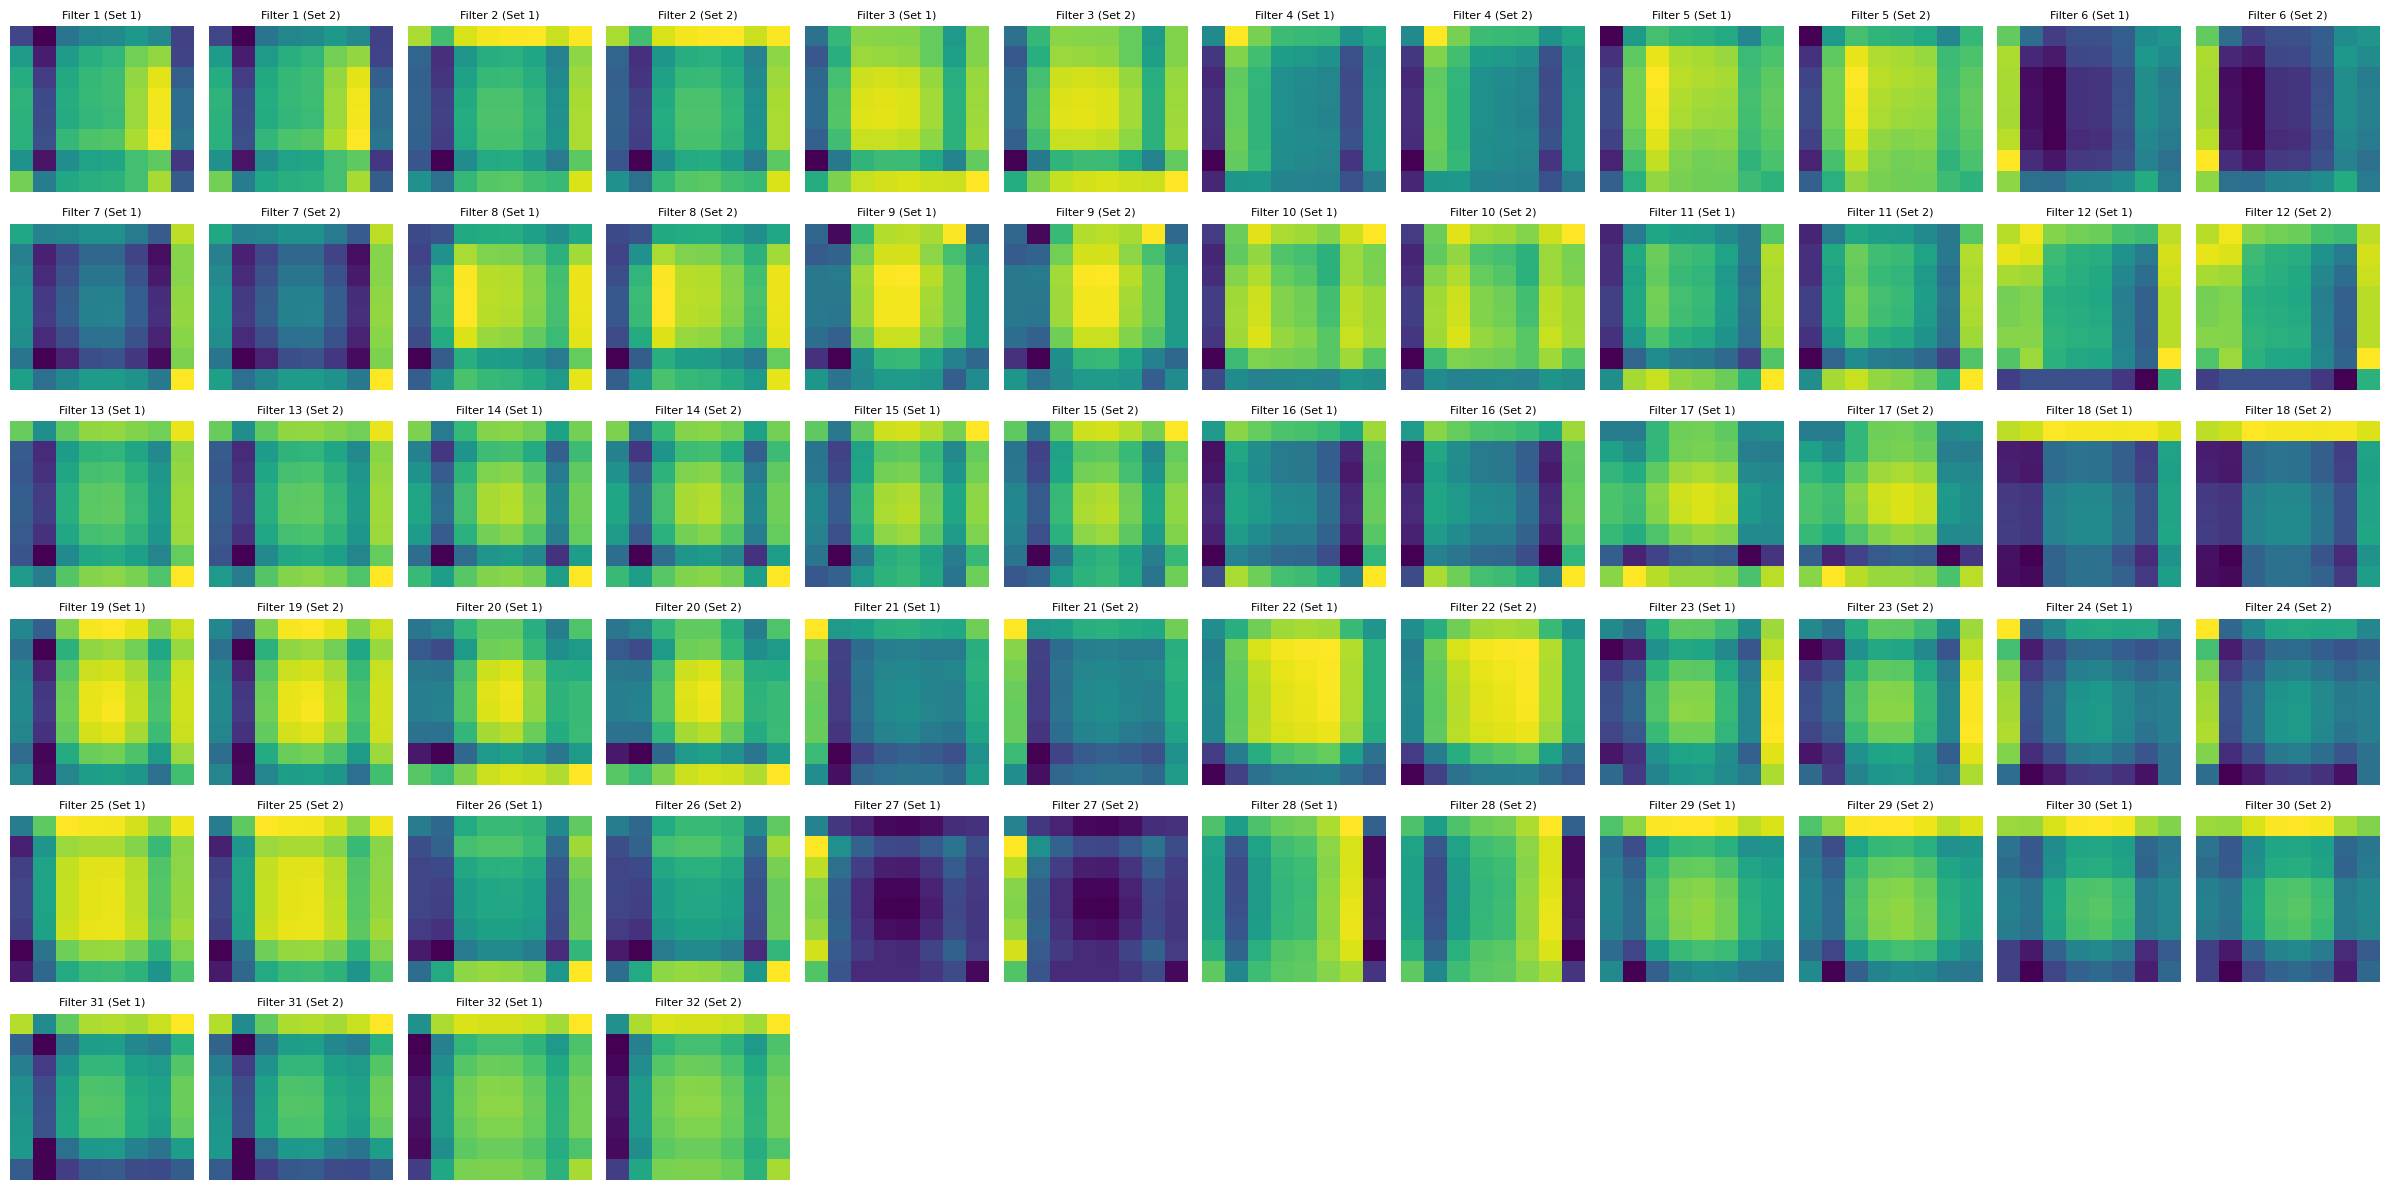

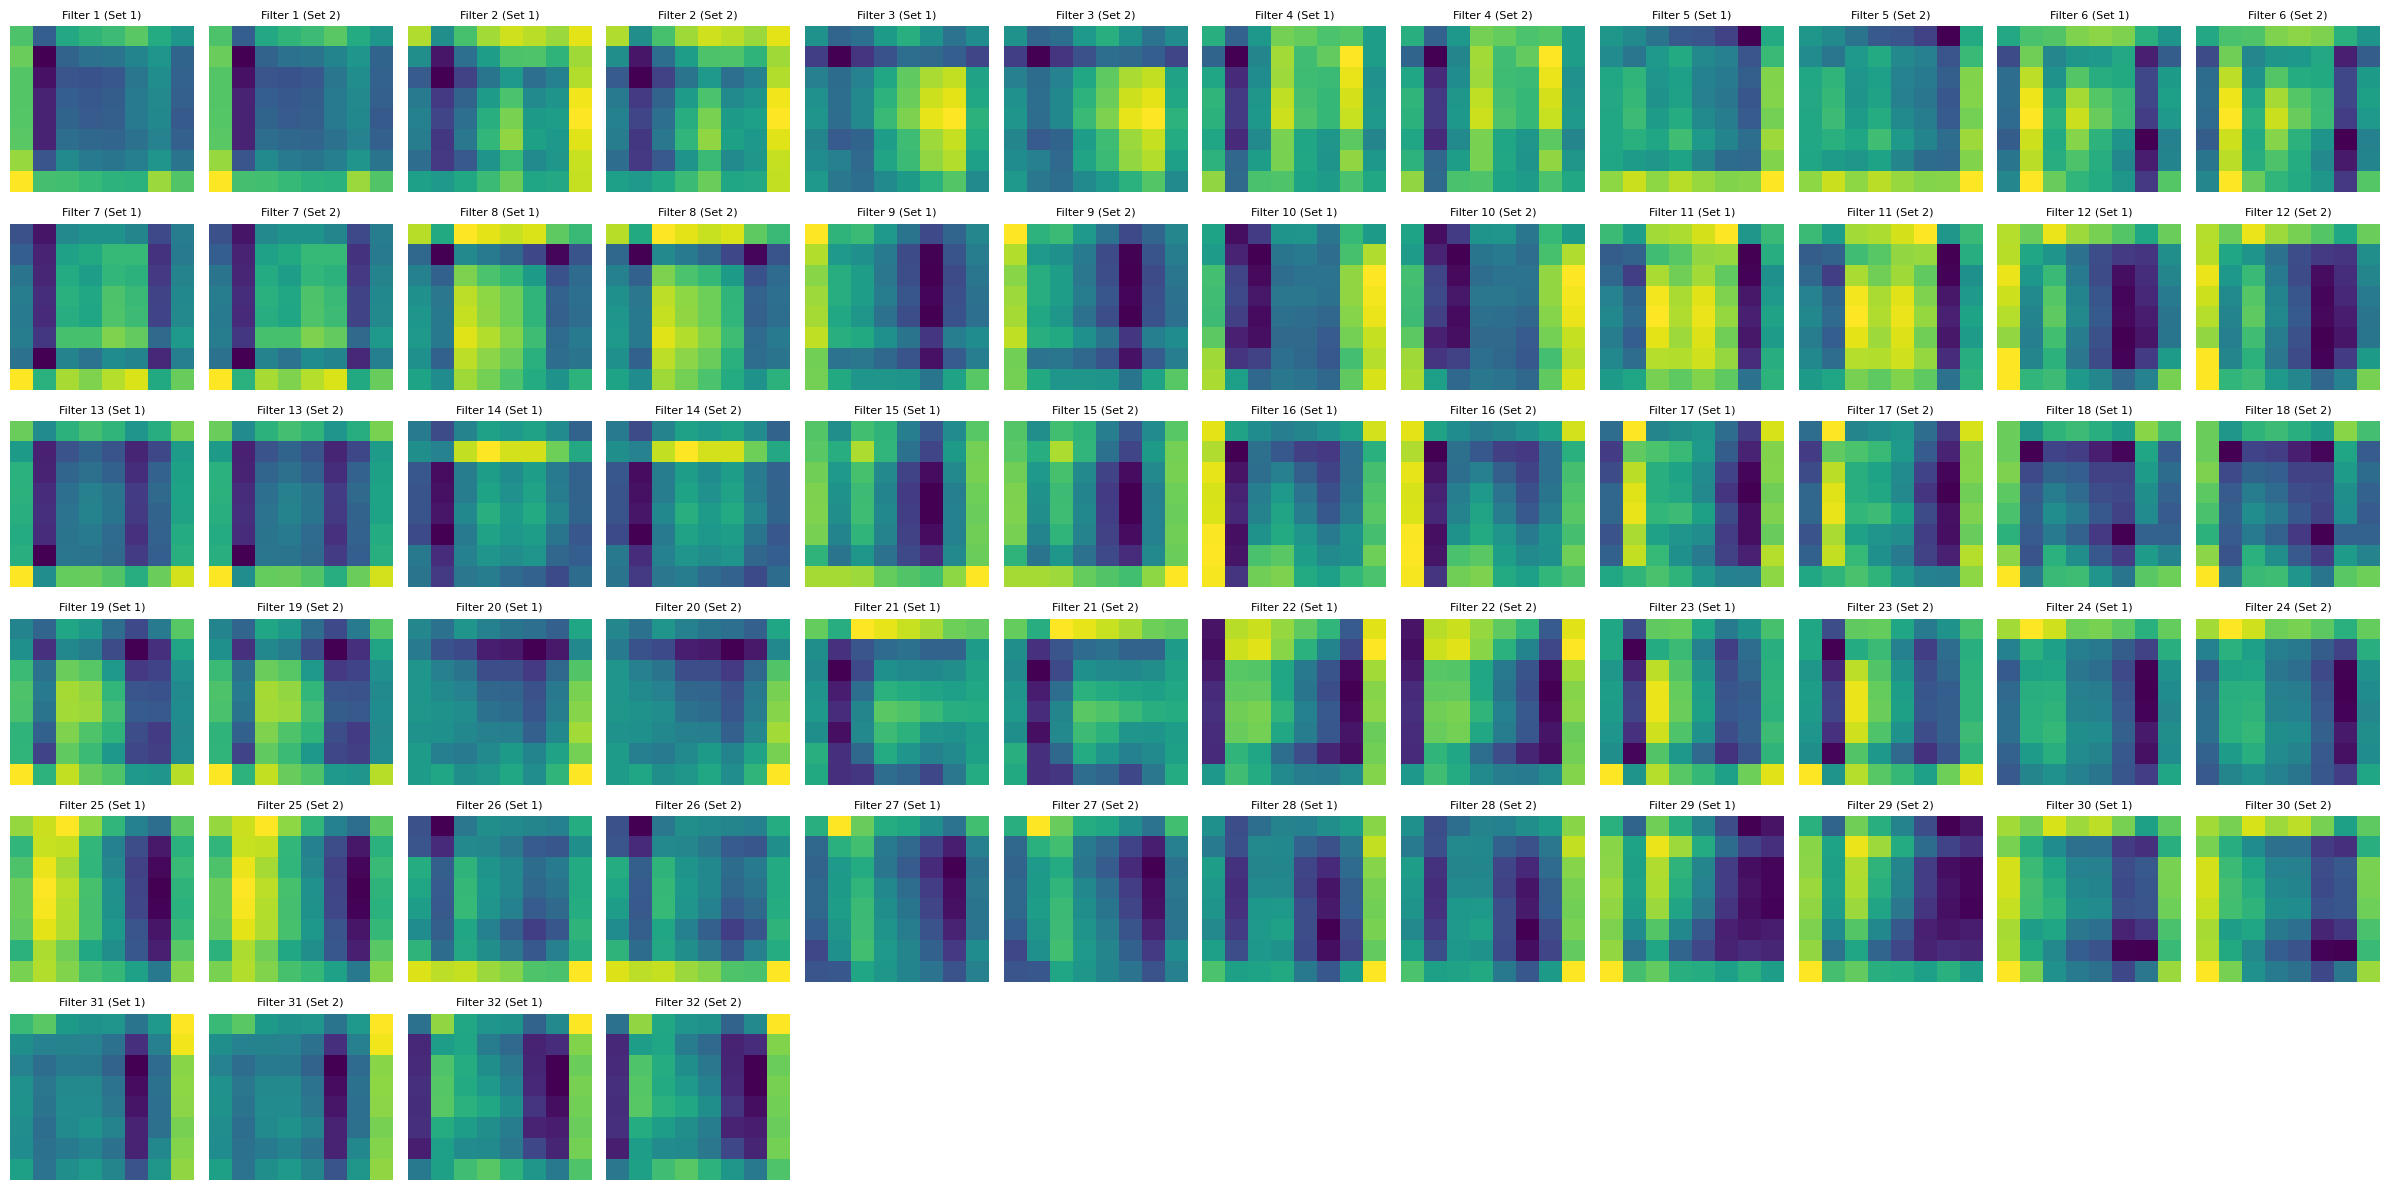

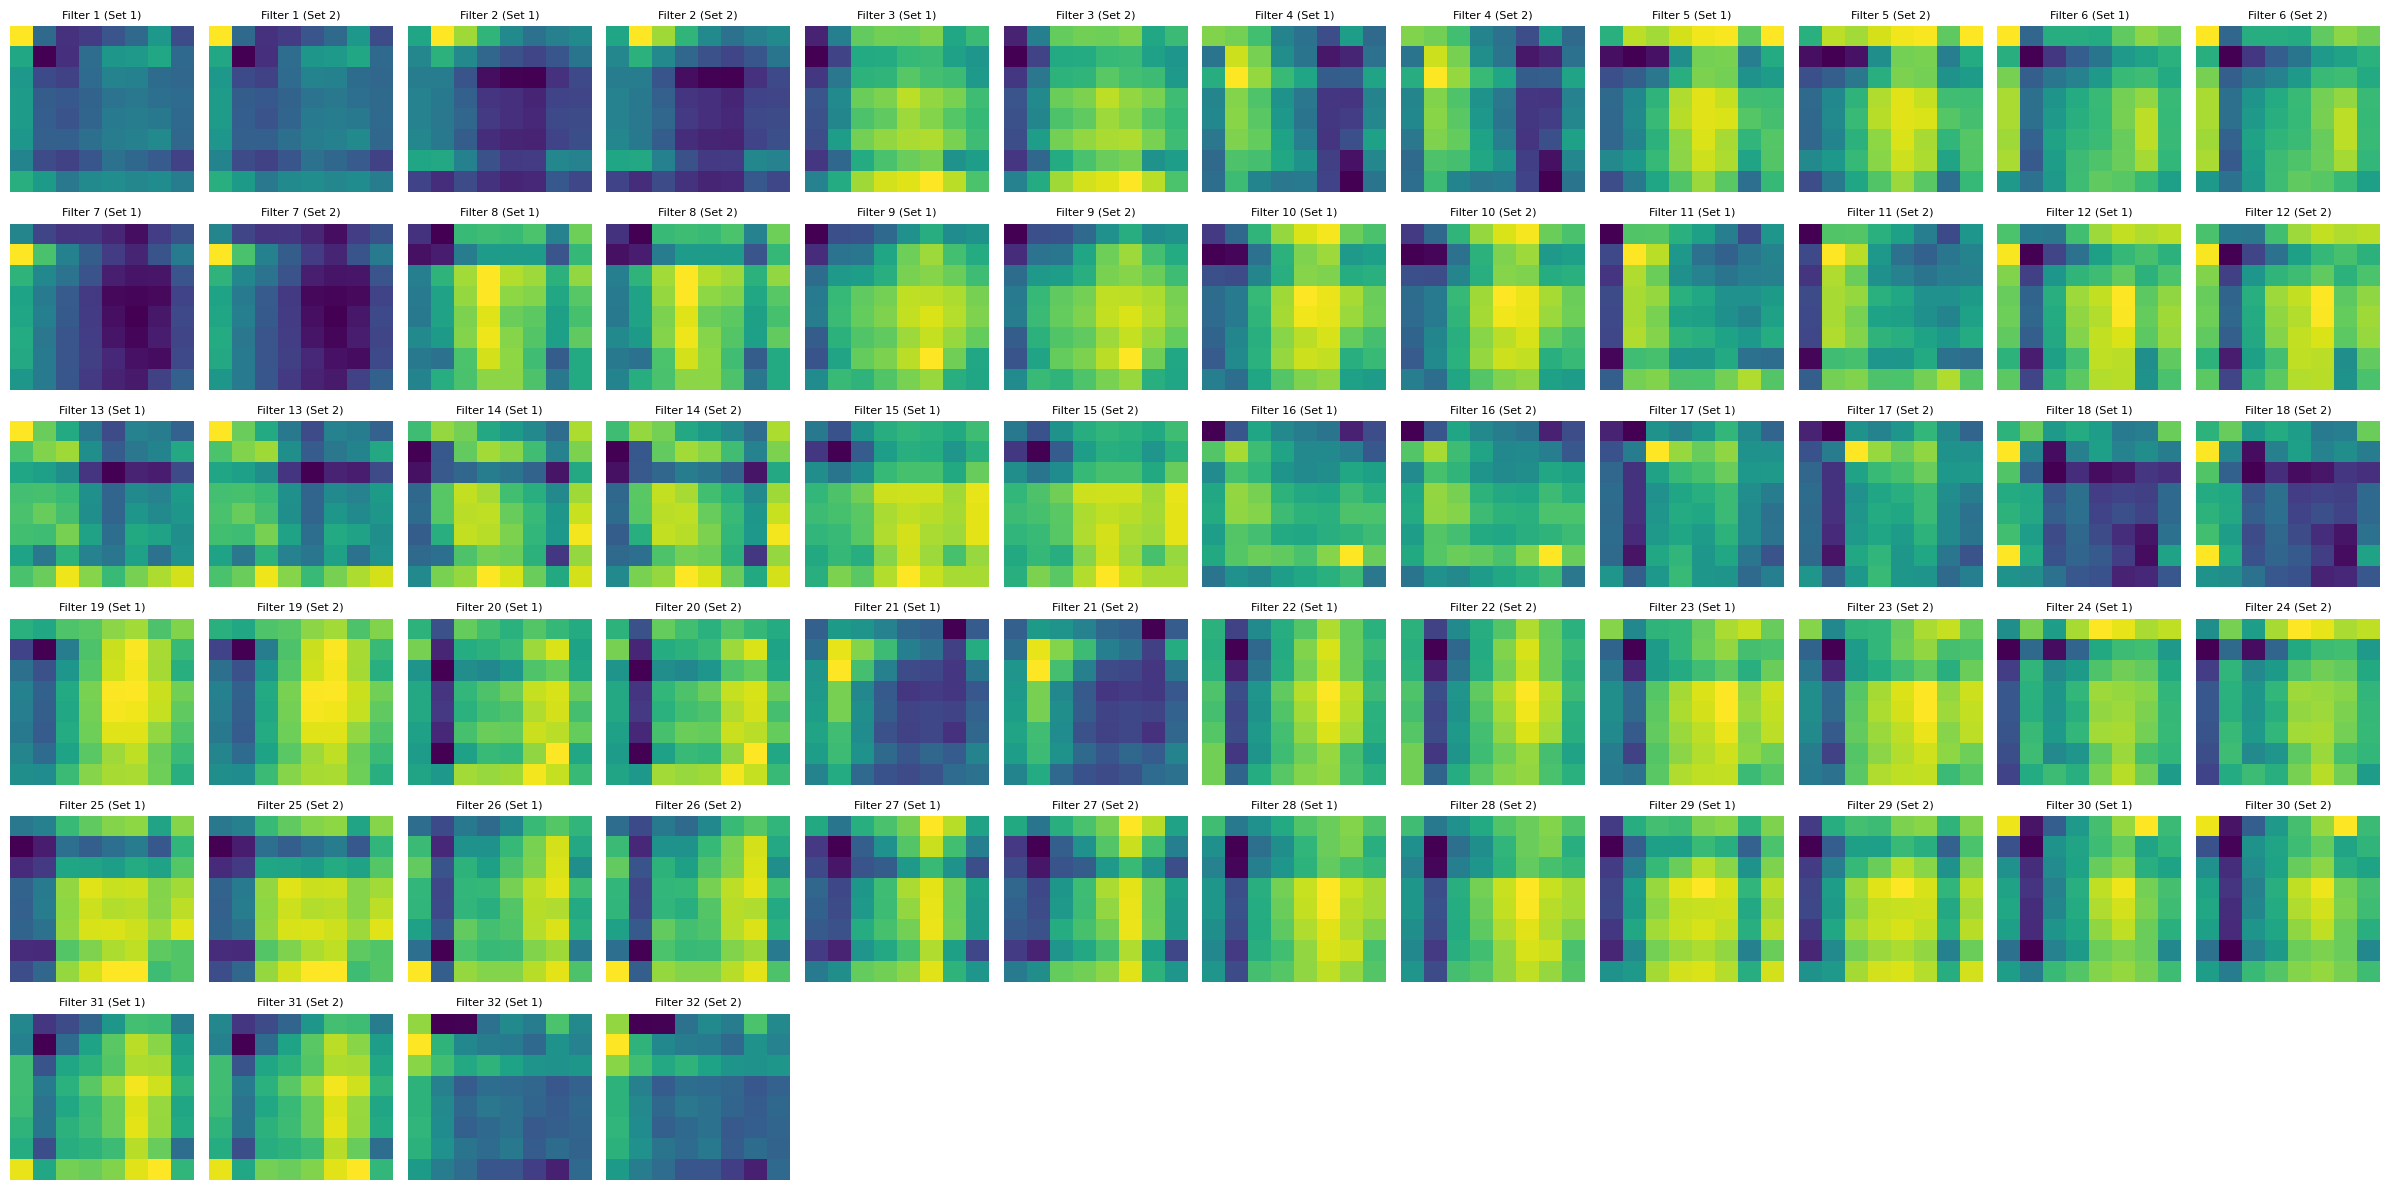

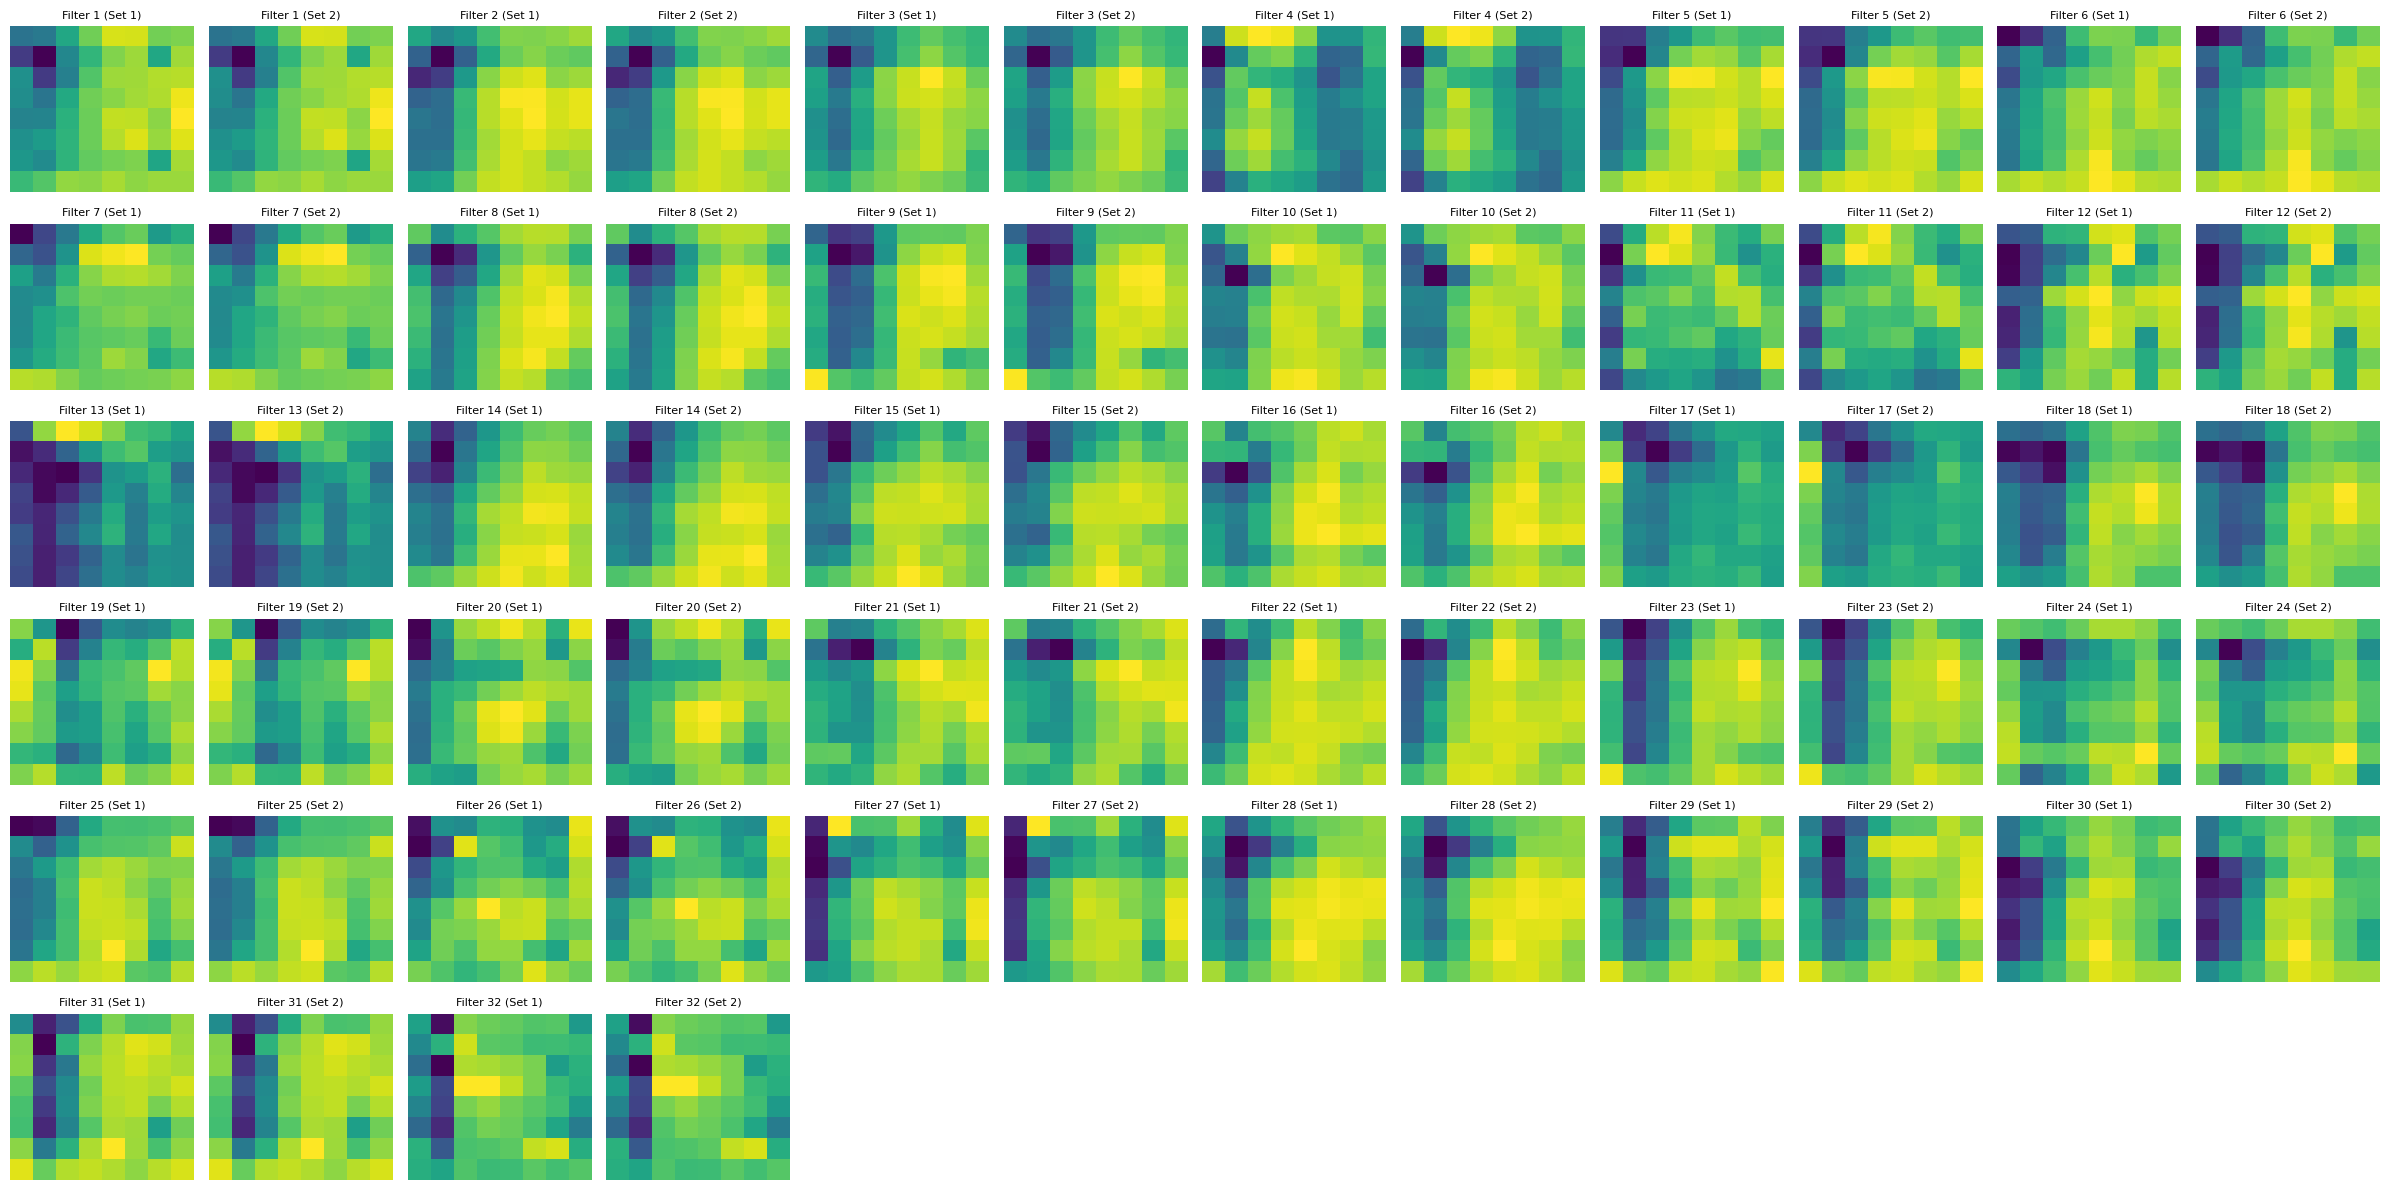

In [ ]:
all_layers = ['conv_seqs_0_conv', 'conv_seqs_0_res_block0_conv0', 'conv_seqs_0_res_block0_conv1', 'conv_seqs_0_res_block1_conv0', 'conv_seqs_0_res_block1_conv1', 'conv_seqs_1_conv', 'conv_seqs_1_res_block0_conv0', 'conv_seqs_1_res_block0_conv1', 'conv_seqs_1_res_block1_conv0', 'conv_seqs_1_res_block1_conv1', 'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1']
later_layers=[    
   'conv_seqs_2_conv', 'conv_seqs_2_res_block0_conv0', 'conv_seqs_2_res_block0_conv1', 'conv_seqs_2_res_block1_conv0', 'conv_seqs_2_res_block1_conv1']

helpers.plot_activations_for_layers_side_by_side(blue_and_green_key_activations,blue_key_only_activations, all_layers)

Episode 1 finished with total reward: 10.0


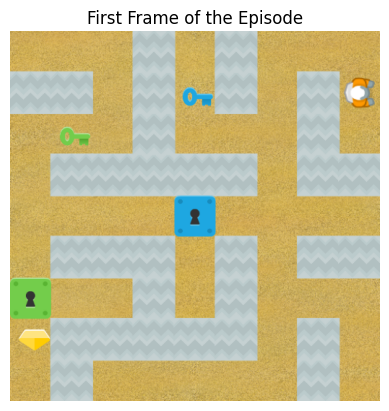

In [ ]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import VecMonitor, VecFrameStack, DummyVecEnv

from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import CheckpointCallback
import torch


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import imageio


import sys
sys.path.append('../') #This is added so we can import from the source folder
from src.policies_impala import ImpalaCNN
from src.visualisation_functions import *


env_name = "procgen:procgen-heist-v0"  

env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 


@torch.no_grad()
def generate_action(model, observation):
    observation = torch.tensor(observation, dtype=torch.float32).unsqueeze(0)

    model_output = model(observation)
    
    logits = model_output[0].logits  # discard the output of the critic in our actor critic network
    
    probabilities = torch.softmax(logits, dim=-1)
    
    action = torch.multinomial(probabilities, 1).item() 
    return action

def load_model(model_path = '../model_1400_latest.pt'):
    observation_space = env.observation_space
    action_space = env.action_space.n
    model = ImpalaCNN(observation_space, action_space)
    model.load_from_file(model_path, device="cpu")
    return model


def run_episode_and_save_as_gif(env, model, filepath='../gifs/run.gif', save_gif=False):

    observations = []
    observation = env.reset()
    done = False
    total_reward = 0
    frames=[]
    
    

    # observation = colour_swap(observation)
    count = 0
    while not done:
        if save_gif:
            frames.append(env.render(mode='rgb_array'))  
        action = generate_action(model, observation)  
        observation, reward, done, info = env.step(action)
        # observation = colour_swap(observation)
        total_reward += reward
        observations.append(observation)
        count +=1
        if count >= 200:
            break

    if save_gif:
        imageio.mimsave(filepath, frames, fps=30) 

    return total_reward, frames, observations
model = load_model()

save_gif_option = True  
for episode in range(1):
    env = gym.make(env_name, start_level=100, num_levels=200, render_mode="rgb_array", distribution_mode="easy") #remove render mode argument to go faster but not produce images 
    total_reward, frames, observations = run_episode_and_save_as_gif(env, model, filepath=f'episode_mod_2_{episode+1}.gif', save_gif=save_gif_option)
    print(f"Episode {episode + 1} finished with total reward: {total_reward}")


if frames:
    plt.imshow(frames[0])
    plt.title("First Frame of the Episode")
    plt.axis('off')  
    plt.show()
else:
    print("No frames captured.")
import imageio

def create_gif(frames, filename, duration=0.1):
    # Write frames to GIF file
    imageio.mimsave(filename, frames, duration=duration)


create_gif(frames, "episode_gif.gif")
